In [103]:
!pip install gymnasium
!pip install pillow

In [104]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.image as mpimg
from PIL import Image

In [105]:
robot_img = mpimg.imread('/content/robot.png')
dirty_img = mpimg.imread('/content/dirt.png')
clean_img = mpimg.imread('/content/clean.png')
obstacle_img = mpimg.imread('/content/obstacle.png')

In [106]:
class VacuumCleanerEnv(gym.Env):
    def __init__(self):
        super(VacuumCleanerEnv, self).__init__()
        self.grid_size = 5
        self.state = (0, 0)
        self.dirty_cells = set([(1, 1), (2, 3), (3, 0), (4, 4)])
        self.obstacles = set([(0, 4), (3, 3), (1, 2)])
        self.cleaned_cells = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) not in self.dirty_cells and (r, c) not in self.obstacles:
                    self.cleaned_cells.add((r, c))
        # Action space initialisation
        self.action_space = spaces.Discrete(6)
        # Observation space
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size)
        ))


    def step(self, action):
        row, col = self.state
        self.previous_state = self.state
        new_state = self.state
        reward = -1  # Any default movement penalty.
        reason = ""
        # Actions and their rewards.
        if action == 0:  # Move up
            if row > 0:
                new_state = (row - 1, col)
                reason = "Moved up"
            else:
                reward = -8
                reason = "Went out of boundary - up"
        elif action == 1:  # Move down
            if row < self.grid_size - 1:
                new_state = (row + 1, col)
                reason = "Moved down"
            else:
                reward = -8
                reason = "Went out of boundary - down"
        elif action == 2:  # Move left
            if col > 0:
                new_state = (row, col - 1)
                reason = "Moved left"
            else:
                reward = -8
                reason = "Went out of boundary - left"
        elif action == 3:  # Move right
            if col < self.grid_size - 1:
                new_state = (row, col + 1)
                reason = "Moved right"
            else:
                reward = -8
                reason = "Went out of boundary - right"
        elif action == 4:  # Clean
            if self.state in self.dirty_cells:
                self.dirty_cells.remove(self.state)
                self.cleaned_cells.add(self.state)
                reward = 20
                reason = "Cleaned dirty cell"
            else:
                reward = -2
                reason = "Cleaned an already clean cell"
        elif action == 5:  # Stay
            reward = -3
            reason = "Stayed in the same position"
        if new_state in self.obstacles:
            reward = -10
            reason = "Ran into an obstacle"
            new_state = self.state
        if new_state != self.state and action in [0, 1, 2, 3]:
            dirty_dist_before = min([abs(row - r) + abs(col - c) for r, c in self.dirty_cells], default=0)
            dirty_dist_after = min([abs(new_state[0] - r) + abs(new_state[1] - c) for r, c in self.dirty_cells], default=0)
            if dirty_dist_after < dirty_dist_before:
                reward = 4
                reason = "Moved closer to dirty cell"
        self.state = new_state
        if self.state in self.dirty_cells and action != 4:
            reward = -5
            reason = "On dirty cell but did not clean"
        self.render()
        print(f"Current State: {self.state}")
        print(f"Previous State: {self.previous_state}")
        print(f"Action Taken: {action_names[action]}")
        print(f"Reward: {reward}")
        print(f"Reason: {reason}")
        done = len(self.dirty_cells) == 0
        return self.state, reward, done, {}


    def reset(self):
        self.state = (0, 0)
        self.dirty_cells = {
            (1, 1), (2, 3), (3, 0), (4, 4)
        }
        self.cleaned_cells = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) not in self.dirty_cells and (r, c) not in self.obstacles:
                    self.cleaned_cells.add((r, c))
        return self.state


    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.clear()
        ax.set_xticks(np.arange(self.grid_size + 1) - 0.5)
        ax.set_yticks(np.arange(self.grid_size + 1) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(color='black', linestyle='-', linewidth=0.5)
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) in self.dirty_cells:
                    ax.imshow(dirty_img, extent=[c - 0.5, c + 0.5, r - 0.5, r + 0.5], aspect='auto', zorder=0)
                elif (r, c) in self.cleaned_cells:
                    ax.imshow(clean_img, extent=[c - 0.5, c + 0.5, r - 0.5, r + 0.5], aspect='auto', zorder=0)
                elif (r, c) in self.obstacles:
                    ax.imshow(obstacle_img, extent=[c - 0.5, c + 0.5, r - 0.5, r + 0.5], aspect='auto', zorder=0)
        ax.imshow(robot_img, extent=[
            self.state[1] - 0.5, self.state[1] + 0.5,
            self.state[0] - 0.5, self.state[0] + 0.5
        ], aspect='auto', zorder=1)
        ax.set_xlim([-0.5, self.grid_size - 0.5])
        ax.set_ylim([-0.5, self.grid_size - 0.5])
        ax.invert_yaxis()
        ax.set_aspect('equal')
        plt.title("Vacuum Cleaner Environment")
        plt.show()


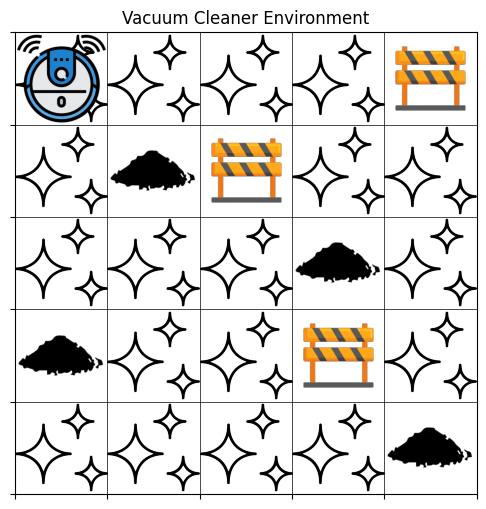

Current State: (0, 0)
Previous State: (0, 0)
Action Taken: Move Left
Reward: -8
Reason: Went out of boundary - left


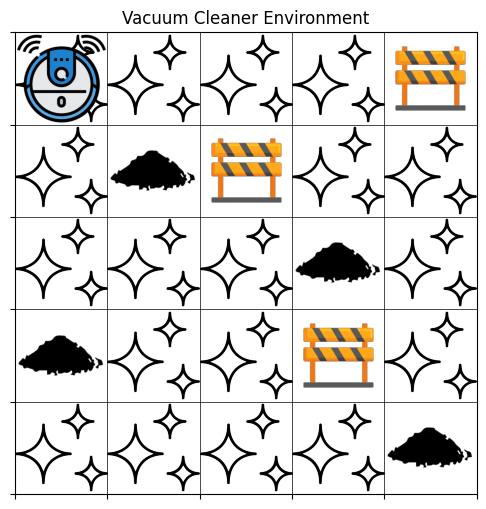

Current State: (0, 0)
Previous State: (0, 0)
Action Taken: Clean
Reward: -2
Reason: Cleaned an already clean cell


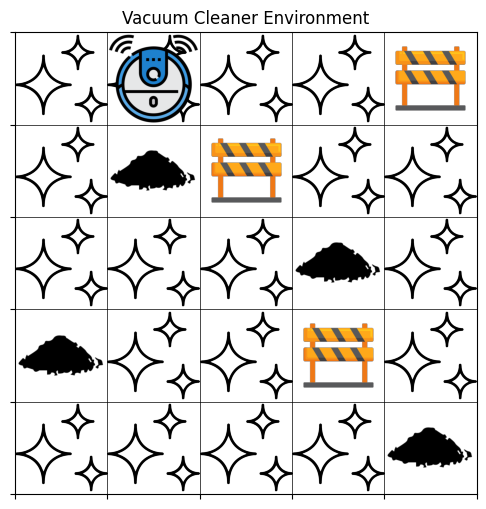

Current State: (0, 1)
Previous State: (0, 0)
Action Taken: Move Right
Reward: 4
Reason: Moved closer to dirty cell


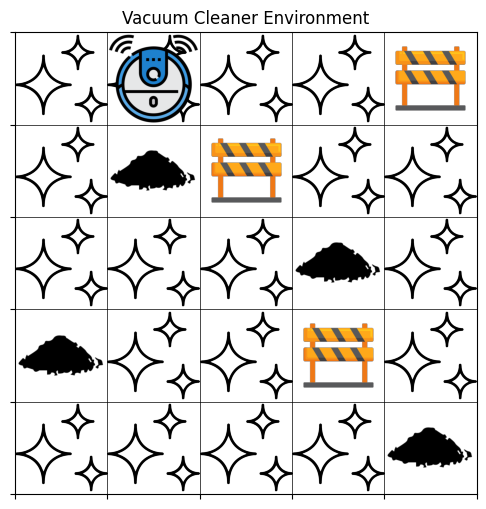

Current State: (0, 1)
Previous State: (0, 1)
Action Taken: Clean
Reward: -2
Reason: Cleaned an already clean cell


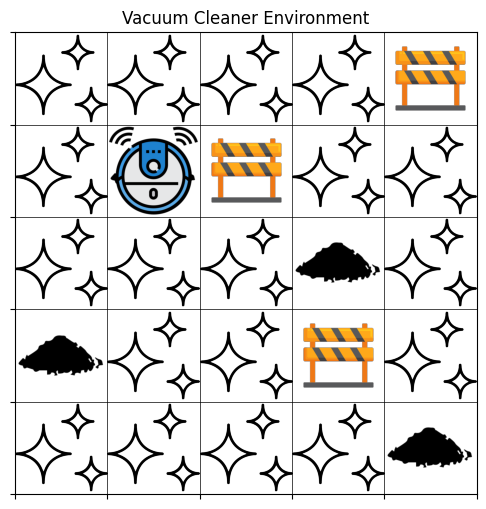

Current State: (1, 1)
Previous State: (0, 1)
Action Taken: Move Down
Reward: -5
Reason: On dirty cell but did not clean


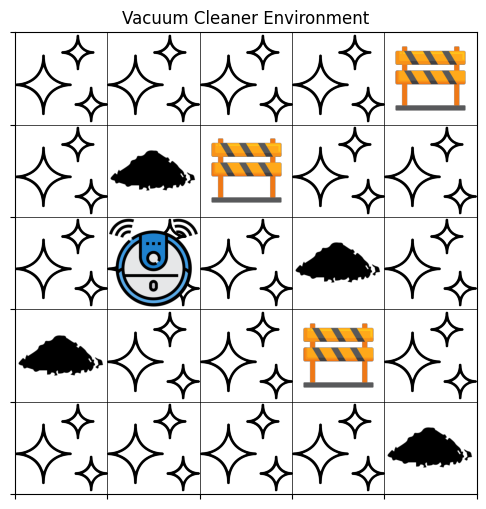

Current State: (2, 1)
Previous State: (1, 1)
Action Taken: Move Down
Reward: -1
Reason: Moved down


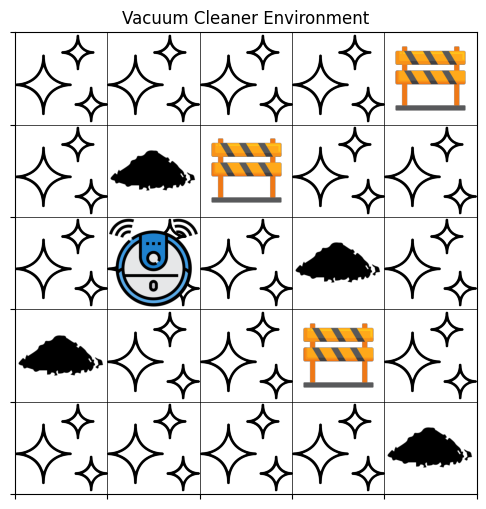

Current State: (2, 1)
Previous State: (2, 1)
Action Taken: Clean
Reward: -2
Reason: Cleaned an already clean cell


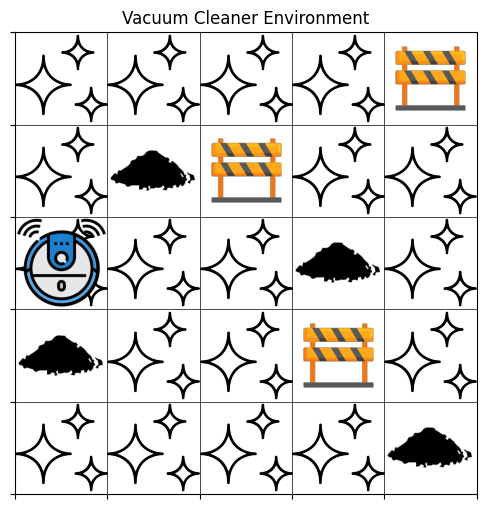

Current State: (2, 0)
Previous State: (2, 1)
Action Taken: Move Left
Reward: -1
Reason: Moved left


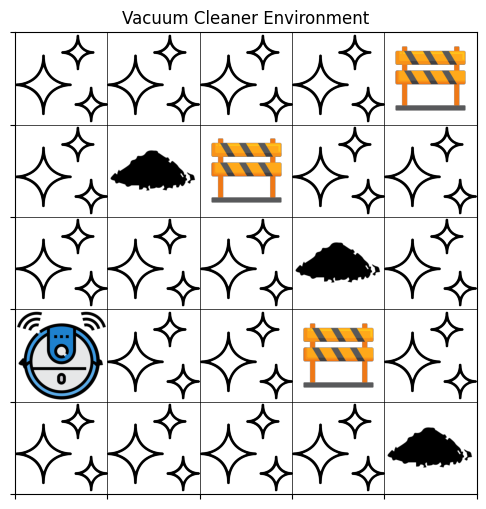

Current State: (3, 0)
Previous State: (2, 0)
Action Taken: Move Down
Reward: -5
Reason: On dirty cell but did not clean


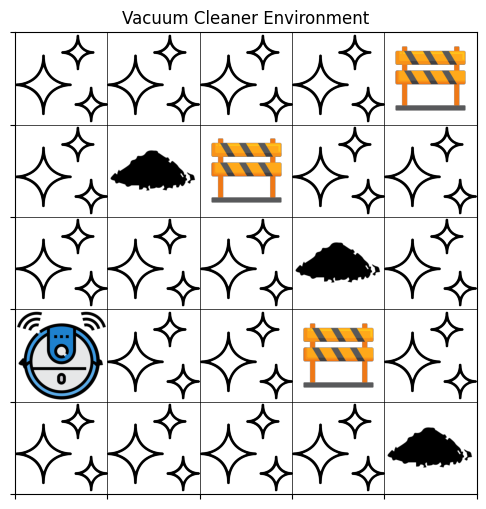

Current State: (3, 0)
Previous State: (3, 0)
Action Taken: Stay
Reward: -5
Reason: On dirty cell but did not clean
Total Reward: -27


In [107]:
action_names = {
    0: "Move Up",
    1: "Move Down",
    2: "Move Left",
    3: "Move Right",
    4: "Clean",
    5: "Stay"
}
env = VacuumCleanerEnv()
state = env.reset()
total_reward = 0
for t in range(10):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
    if done:
        print("Environment solved.")
        break
print(f"Total Reward: {total_reward}")

##  Defining Warehouse Robot Environment

In [108]:
class WarehouseRobotEnv(gym.Env):
    def __init__(self):
        super(WarehouseRobotEnv, self).__init__()
        self.grid_size = 6
        self.state = ((0, 0), False)  # (position, has_item)
        self.obstacles = {(1, 1), (2, 3), (3, 2), (4, 4), (5, 1)}
        self.pickup_location = (0, 1)
        self.dropoff_location = (5, 5)
        self.action_space = spaces.Discrete(6)  # Up, Down, Left, Right, Pick-up, Drop-off
        self.observation_space = spaces.Tuple((
            spaces.Tuple((spaces.Discrete(self.grid_size), spaces.Discrete(self.grid_size))),
            spaces.Discrete(2)
        ))

        self.empty_img = np.ones((1, 1, 3))
        self.obstacle_img = mpimg.imread('obstacle1.jpg')
        self.robot_img = mpimg.imread('robot1.png')
        self.pickup_img = mpimg.imread('pickup.png')
        self.dropoff_img = mpimg.imread('house.png')


        self.robot_img = np.rot90(self.robot_img, k=2)
        self.obstacle_img = np.rot90(self.obstacle_img, k=2)
        self.pickup_img = np.rot90(self.pickup_img, k=2)
        self.dropoff_img = np.rot90(self.dropoff_img, k=2)

    def step(self, action):
        position, has_item = self.state
        row, col = position
        new_position = position
        reward = -1
        done = False
        reason = ""


        if action == 0 and row > 0:  # Move up
            new_position = (row - 1, col)
            reason = "Moved up"
        elif action == 1 and row < self.grid_size - 1:  # Move down
            new_position = (row + 1, col)
            reason = "Moved down"
        elif action == 2 and col > 0:  # Move left
            new_position = (row, col - 1)
            reason = "Moved left"
        elif action == 3 and col < self.grid_size - 1:  # Move right
            new_position = (row, col + 1)
            reason = "Moved right"
        else:
            reason = "Went out of boundary"
            new_position = position


        if new_position in self.obstacles:
            new_position = position
            reward = -20
            reason = "Hit obstacle"


        if action == 4:
            if position == self.pickup_location and not has_item:
                has_item = True
                reward = 25
                reason = "Picked up item"
            else:
                reason = "Failed to pick up"
        elif action == 5:  # Drop-off
            if position == self.dropoff_location and has_item:
                has_item = False
                reward = 100
                done = True
                reason = "Delivered item"
            else:
                reason = "Failed to drop off"


        self.state = (new_position, has_item)
        return self.state, reward, done, {"reason": reason}

    def reset(self):
        self.state = ((0, 0), False)
        return self.state

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.clear()


        ax.set_xticks(np.arange(self.grid_size + 1) - 0.5)
        ax.set_yticks(np.arange(self.grid_size + 1) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(color='black', linestyle='-', linewidth=0.5)


        for row in range(self.grid_size):
            for col in range(self.grid_size):
                if (row, col) in self.obstacles:
                    ax.imshow(self.obstacle_img, extent=[col - 0.5, col + 0.5, row - 0.5, row + 0.5], aspect='auto', zorder=0)
                elif (row, col) == self.pickup_location:
                    ax.imshow(self.pickup_img, extent=[col - 0.5, col + 0.5, row - 0.5, row + 0.5], aspect='auto', zorder=0)
                elif (row, col) == self.dropoff_location:
                    ax.imshow(self.dropoff_img, extent=[col - 0.5, col + 0.5, row - 0.5, row + 0.5], aspect='auto', zorder=0)
                else:
                    ax.add_patch(Rectangle((col - 0.5, row - 0.5), 1, 1, color='white', zorder=0))


        robot_row, robot_col = self.state[0]
        ax.imshow(self.robot_img, extent=[
            robot_col - 0.5, robot_col + 0.5,
            robot_row - 0.5, robot_row + 0.5
        ], aspect='auto', zorder=1)


        ax.set_xlim([-0.5, self.grid_size - 0.5])
        ax.set_ylim([-0.5, self.grid_size - 0.5])
        ax.invert_yaxis()
        ax.set_aspect('equal')


        robot_pos, has_item = self.state
        plt.title(f"Robot at {robot_pos}, Has item: {has_item}")
        plt.show()


Random Agent for 10 Episodes:
Episode 1: Initial State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



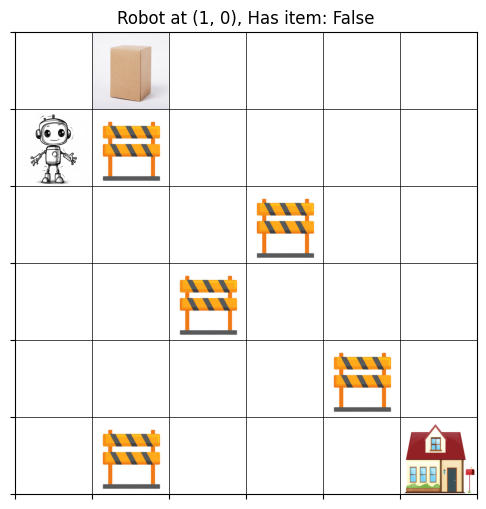

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



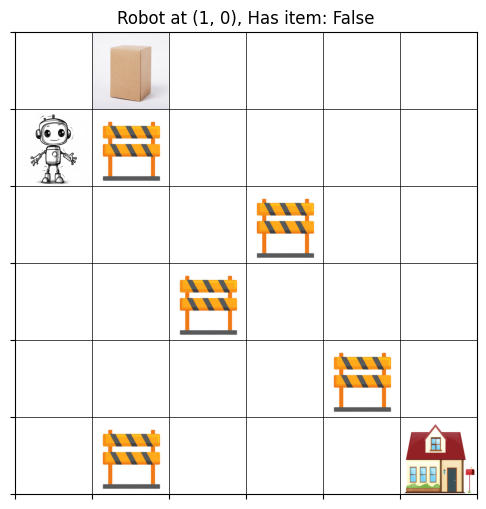

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



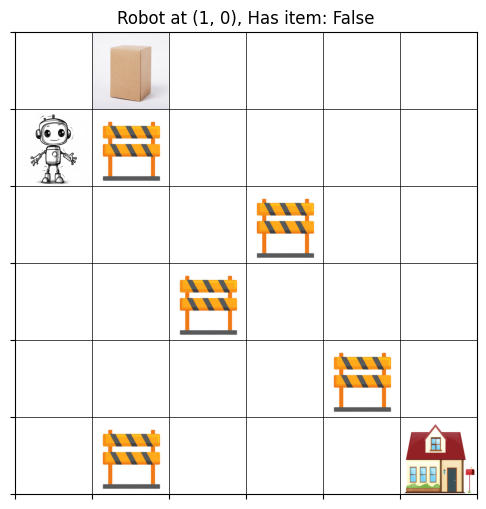

Previous State: ((1, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



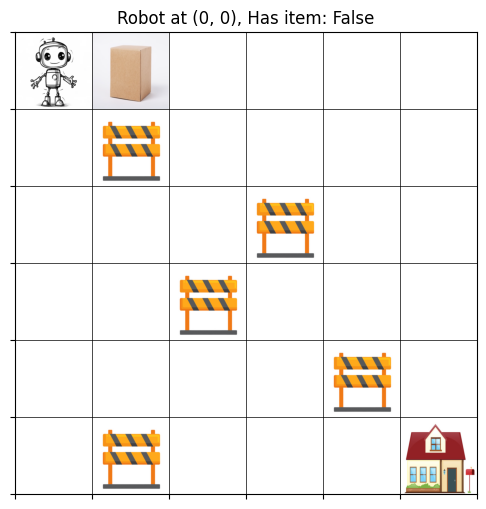

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



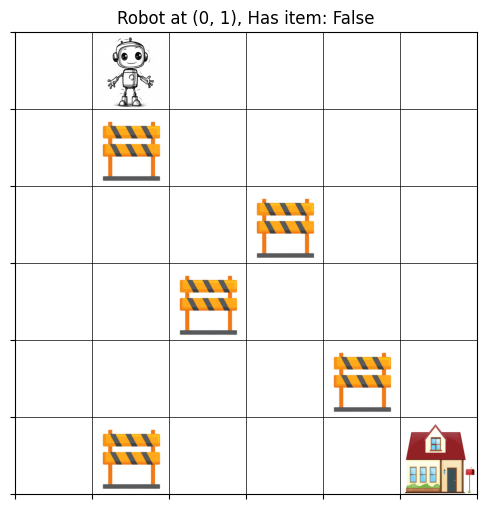

Previous State: ((0, 1), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Moved left



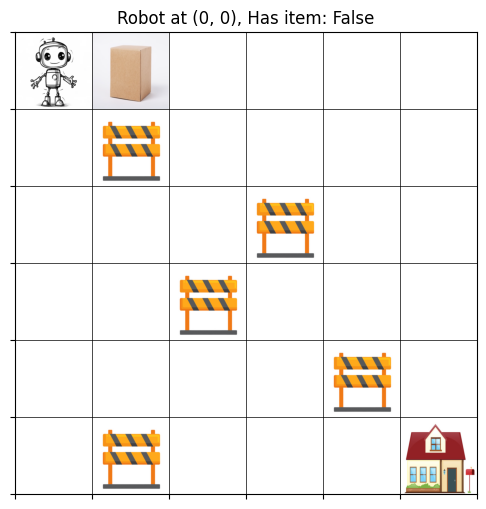

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



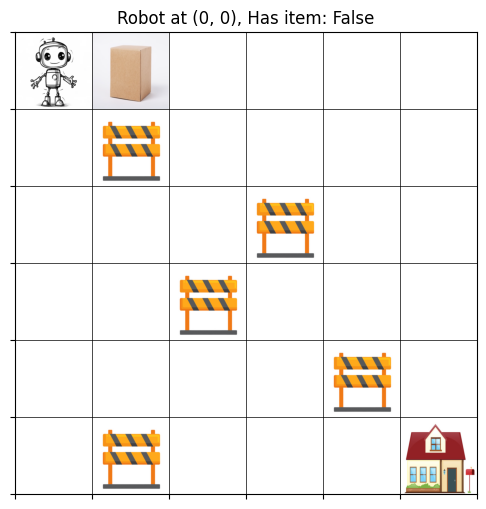

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



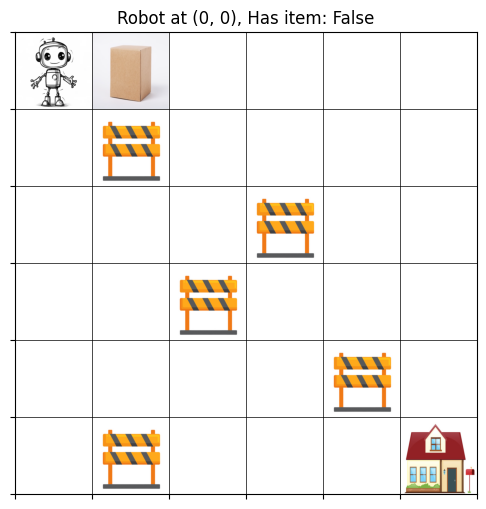

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



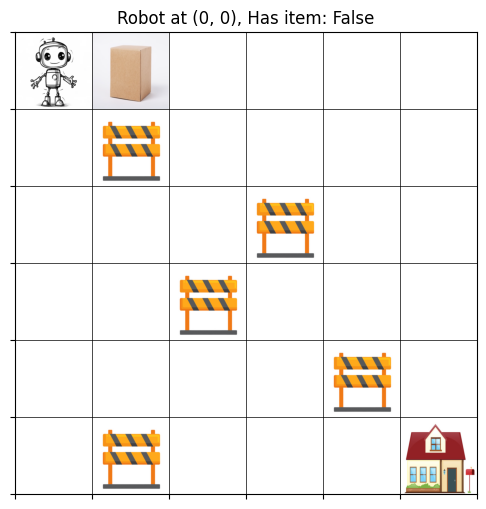

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



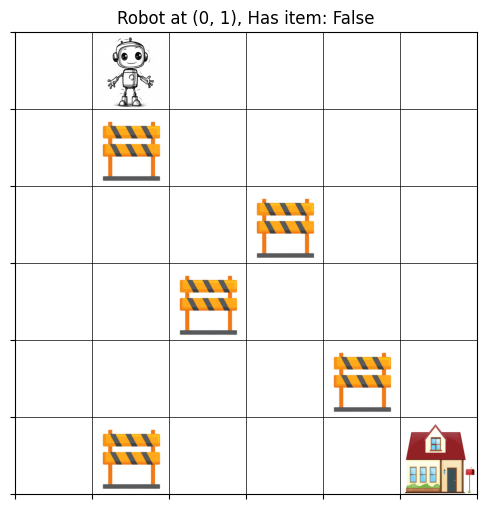



Episode 2: Initial State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



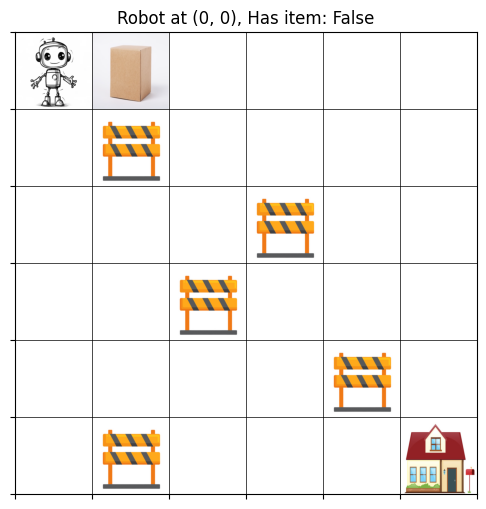

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



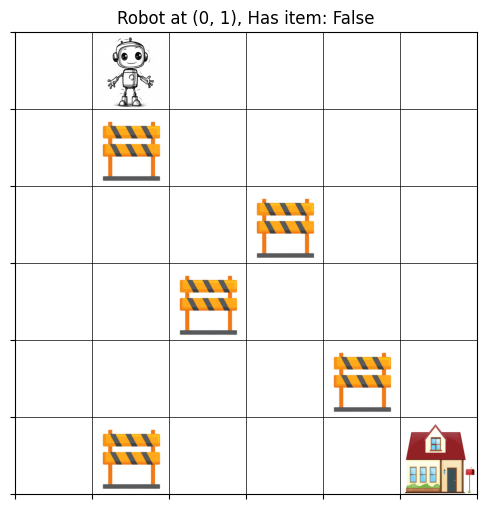

Previous State: ((0, 1), False)
Current State: ((0, 1), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



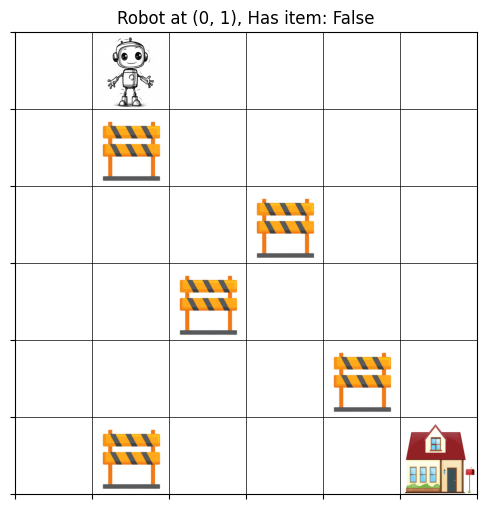

Previous State: ((0, 1), False)
Current State: ((0, 1), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



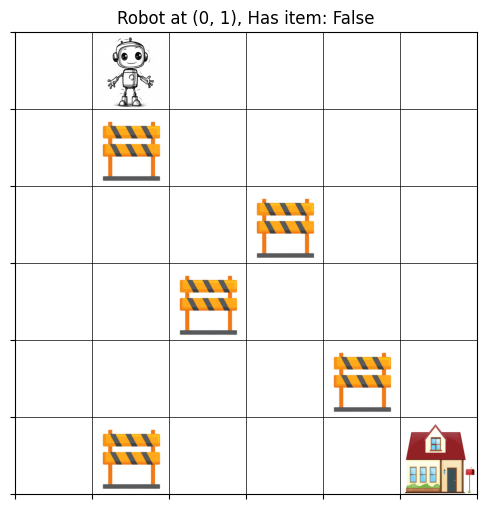

Previous State: ((0, 1), False)
Current State: ((0, 2), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



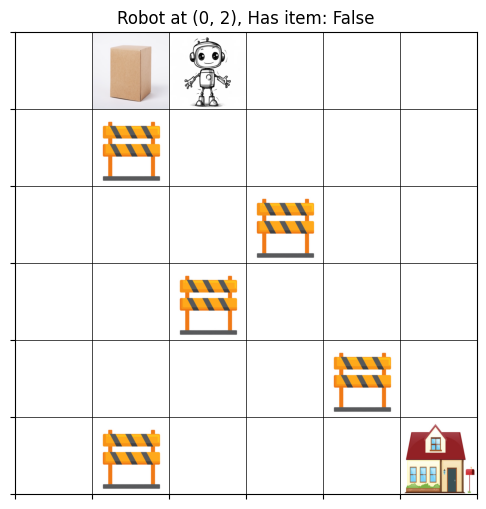

Previous State: ((0, 2), False)
Current State: ((0, 3), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



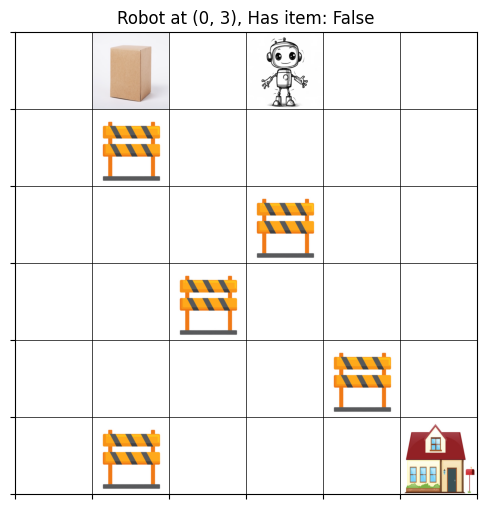

Previous State: ((0, 3), False)
Current State: ((0, 3), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



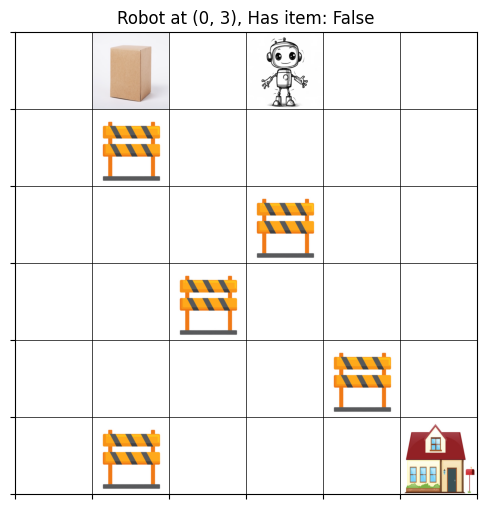

Previous State: ((0, 3), False)
Current State: ((0, 3), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



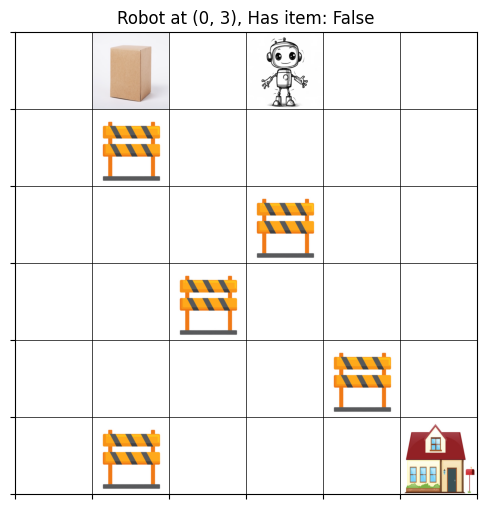

Previous State: ((0, 3), False)
Current State: ((0, 3), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



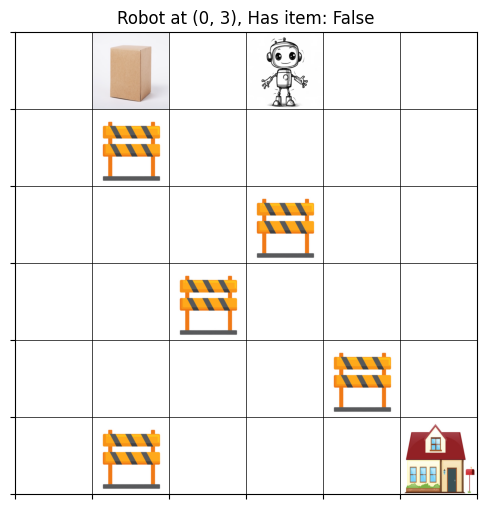

Previous State: ((0, 3), False)
Current State: ((0, 3), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



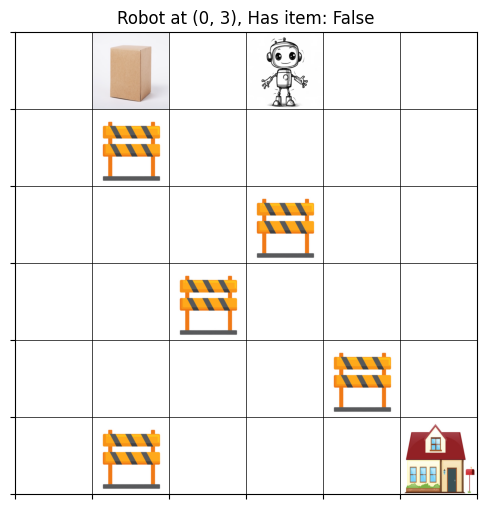



Episode 3: Initial State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



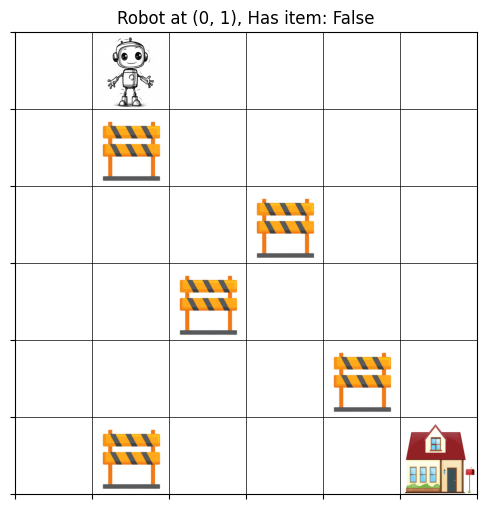

Previous State: ((0, 1), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Moved left



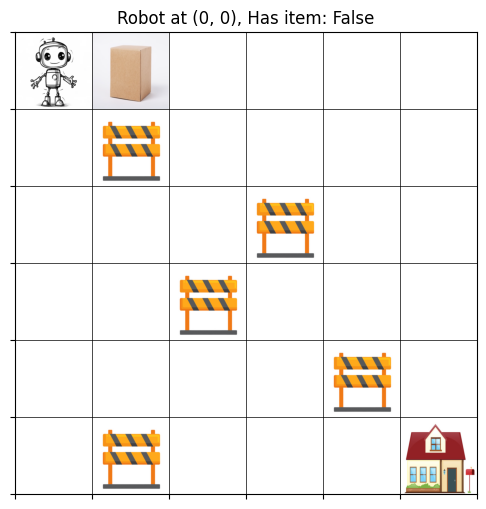

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



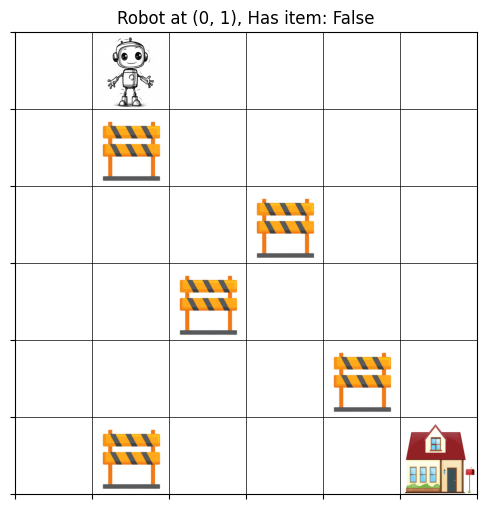

Previous State: ((0, 1), False)
Current State: ((0, 1), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



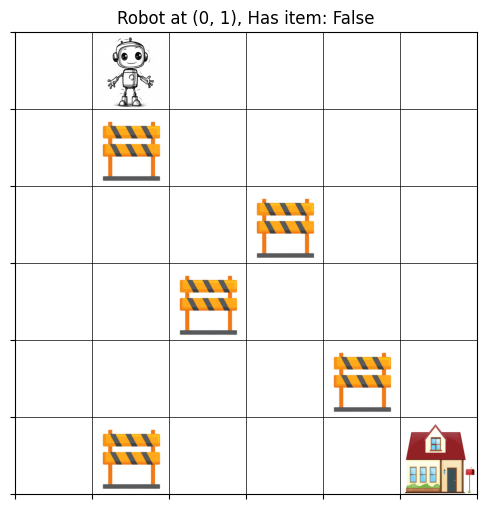

Previous State: ((0, 1), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Moved left



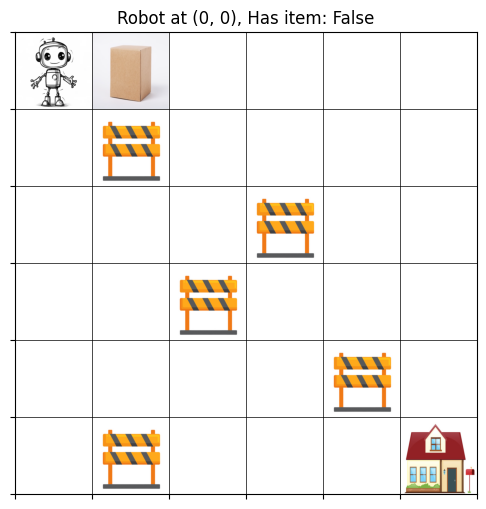

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



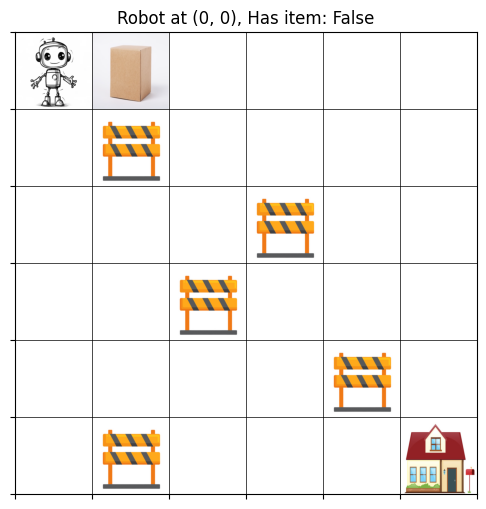

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



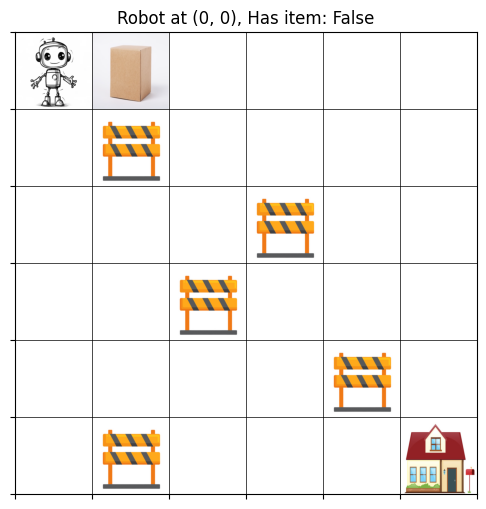

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



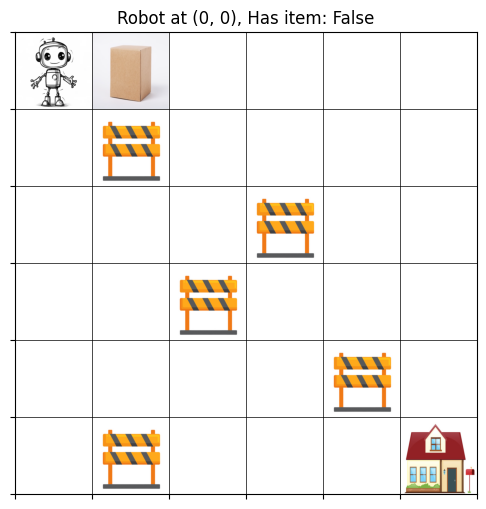

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



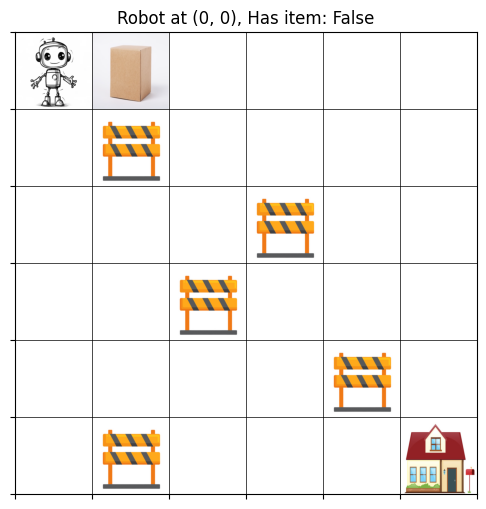

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



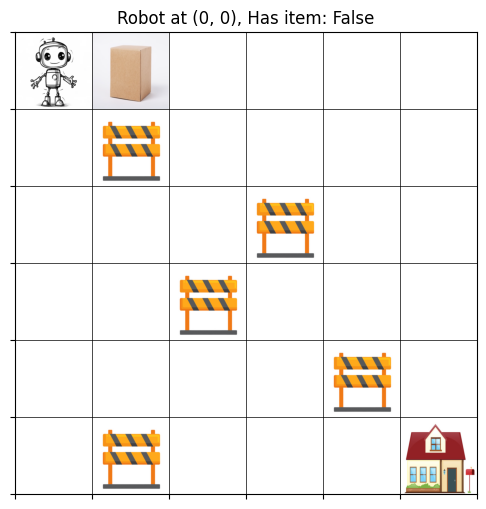



Episode 4: Initial State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



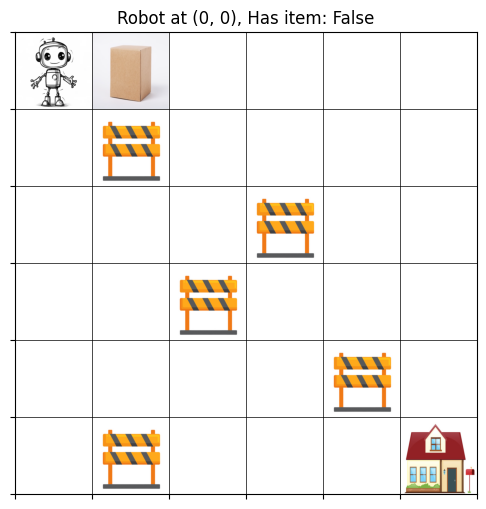

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



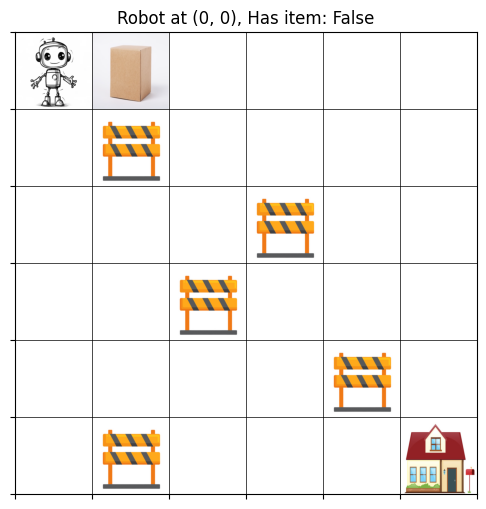

Previous State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



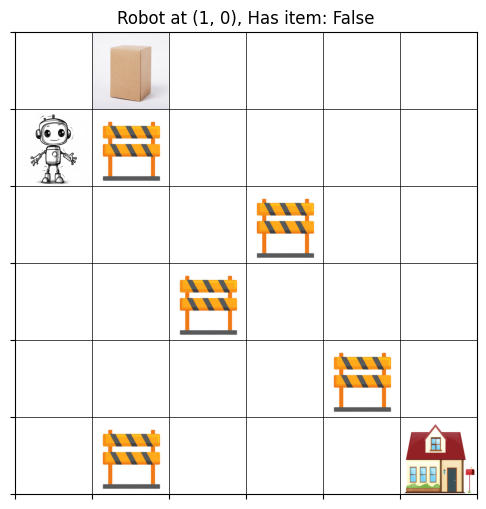

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



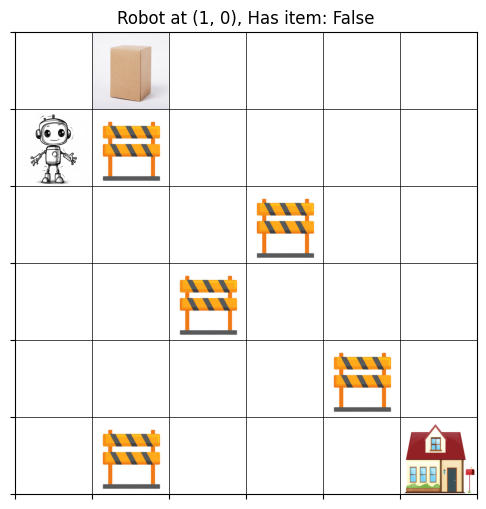

Previous State: ((1, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



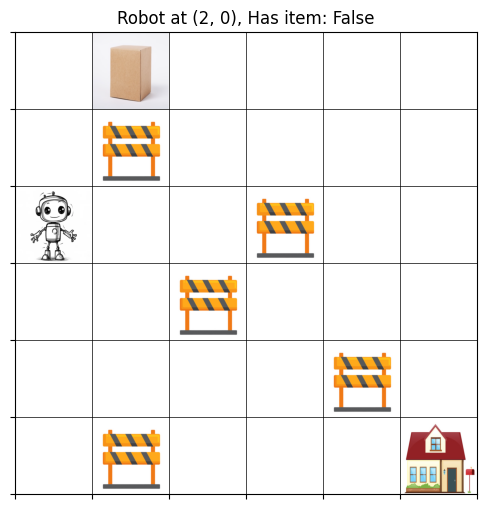

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



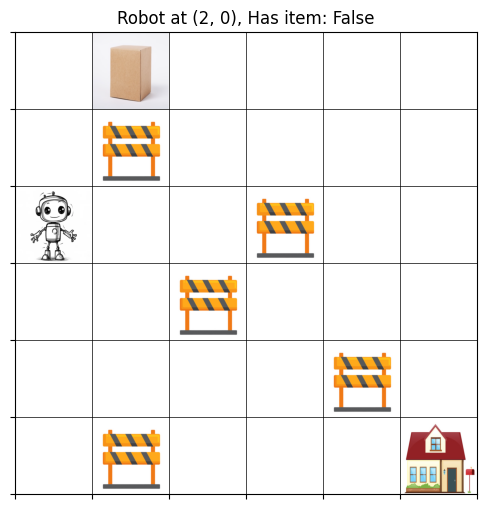

Previous State: ((2, 0), False)
Current State: ((2, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



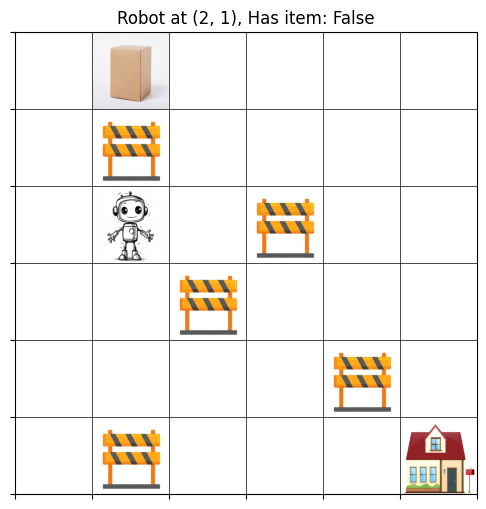

Previous State: ((2, 1), False)
Current State: ((2, 1), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



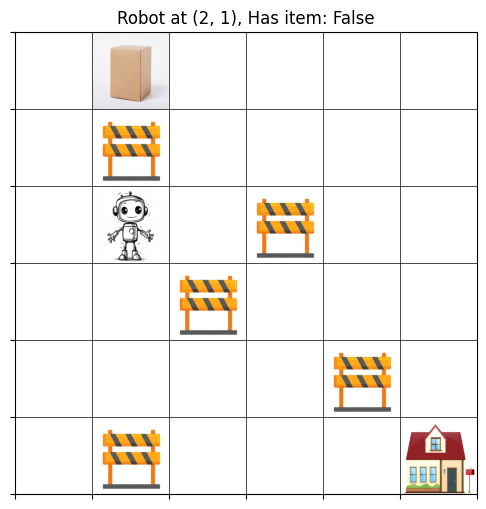

Previous State: ((2, 1), False)
Current State: ((2, 1), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



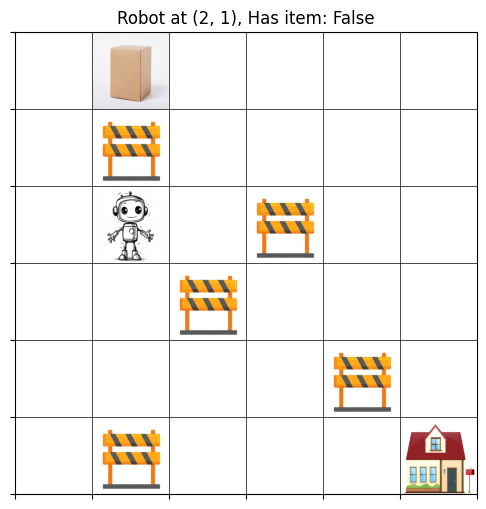

Previous State: ((2, 1), False)
Current State: ((2, 2), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



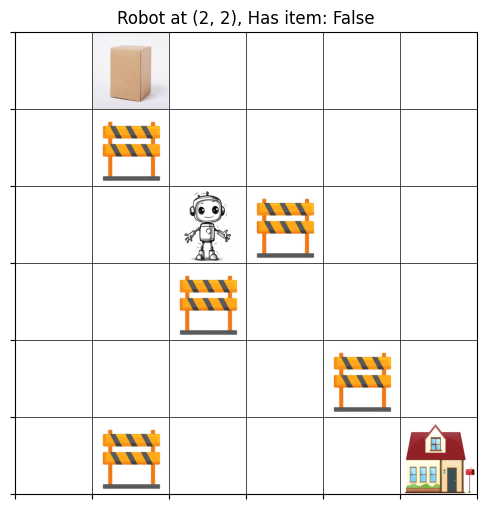



Episode 5: Initial State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



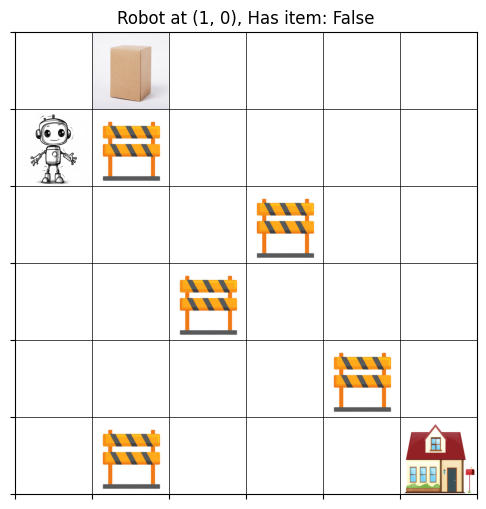

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



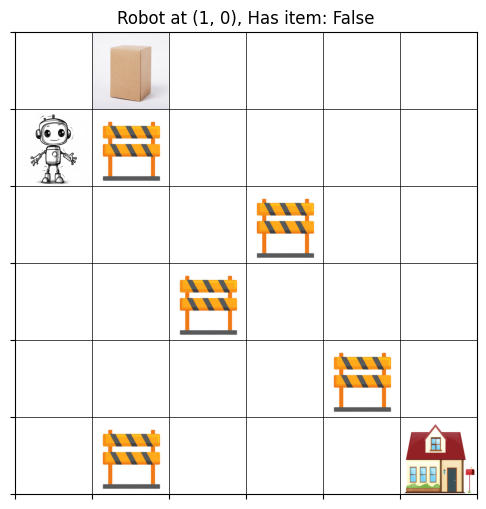

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



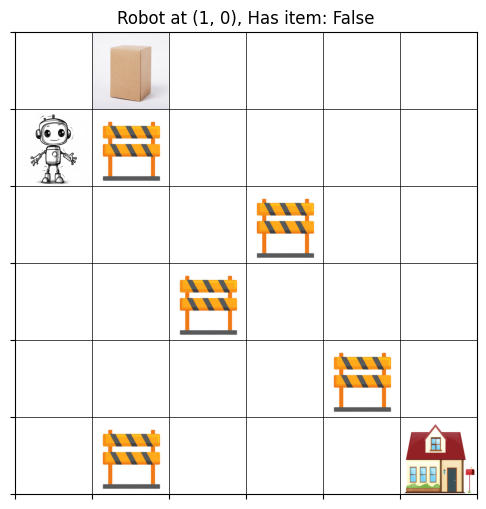

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



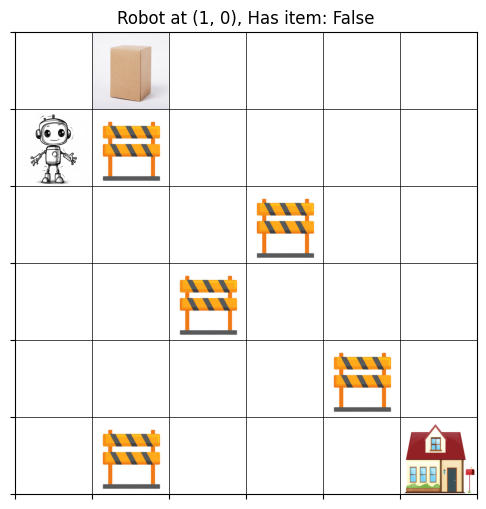

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



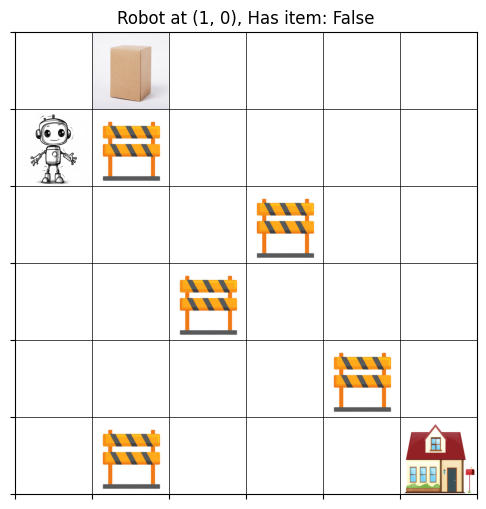

Previous State: ((1, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



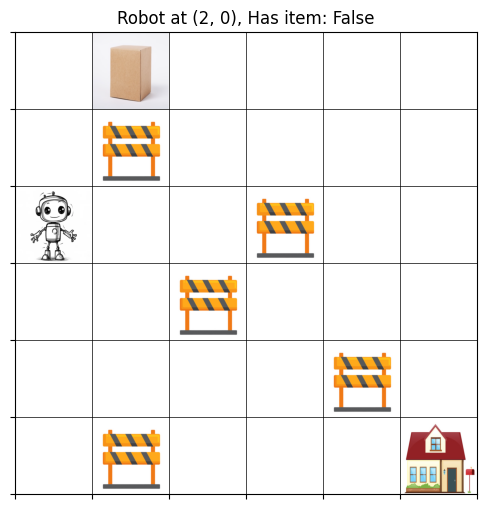

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



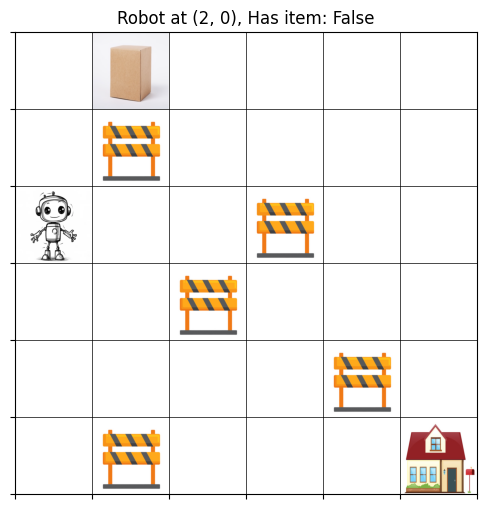

Previous State: ((2, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



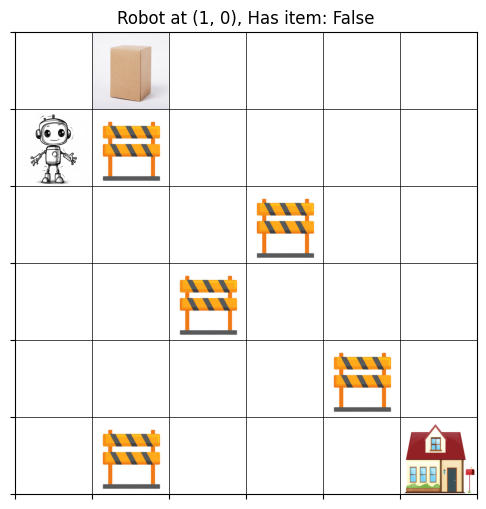

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



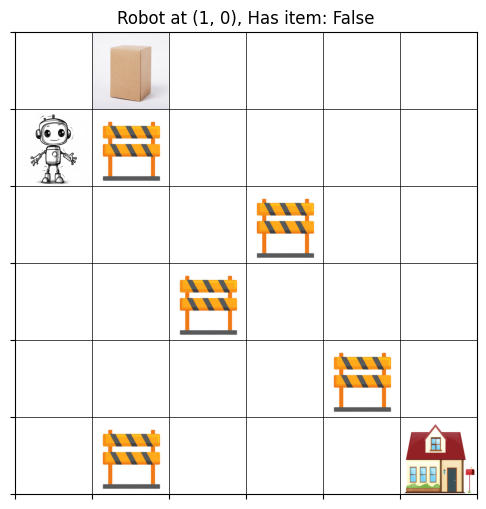

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Right
Reward: -20
Reason: Hit obstacle



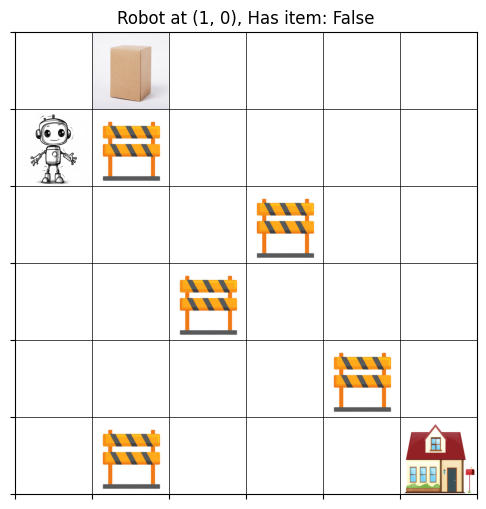



Episode 6: Initial State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



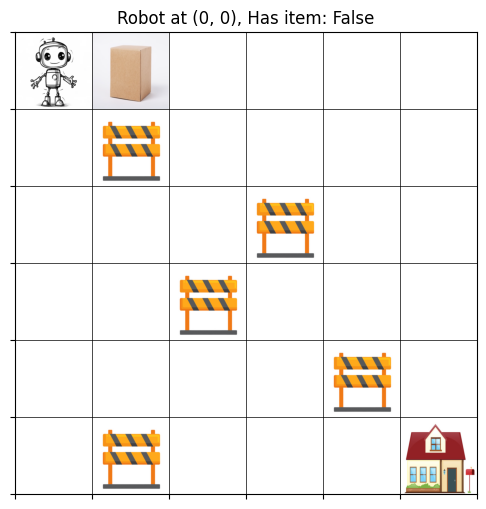

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



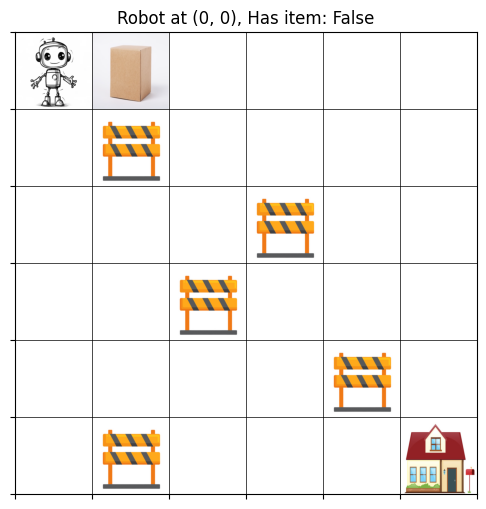

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



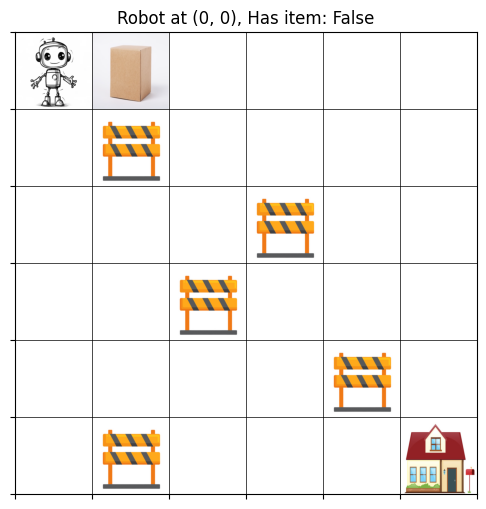

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



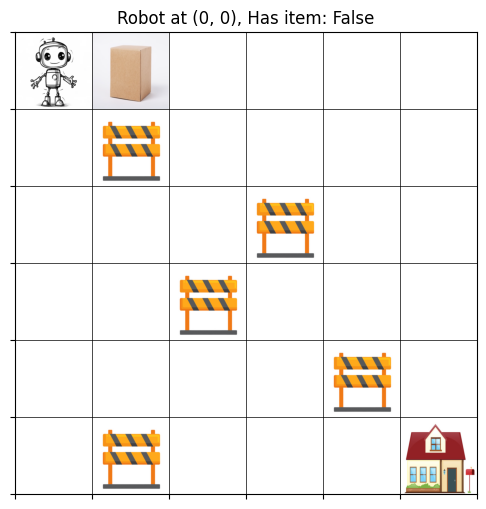

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



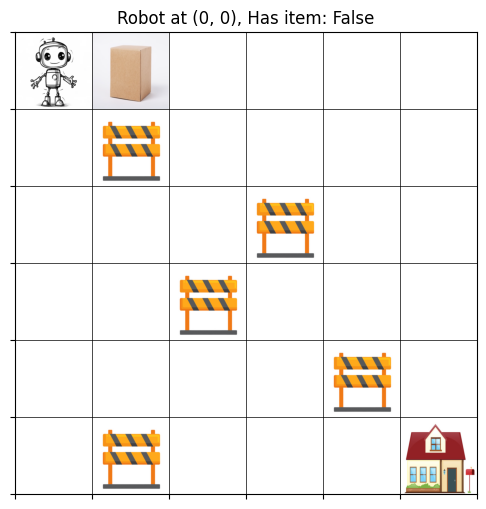

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



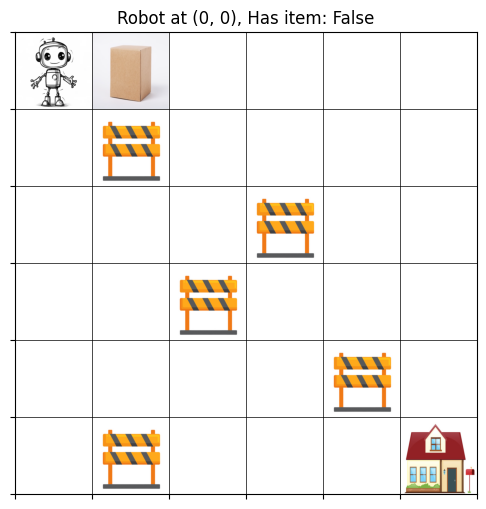

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



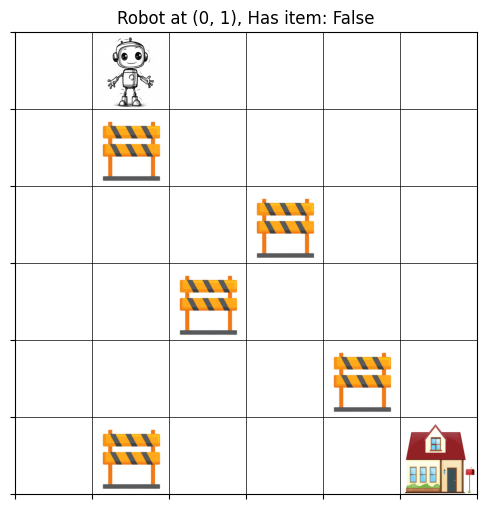

Previous State: ((0, 1), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Moved left



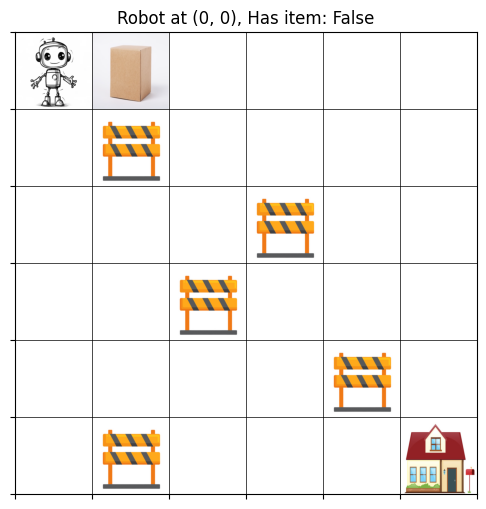

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



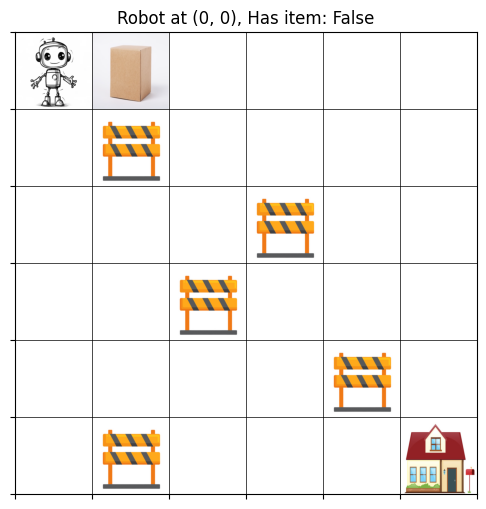

Previous State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



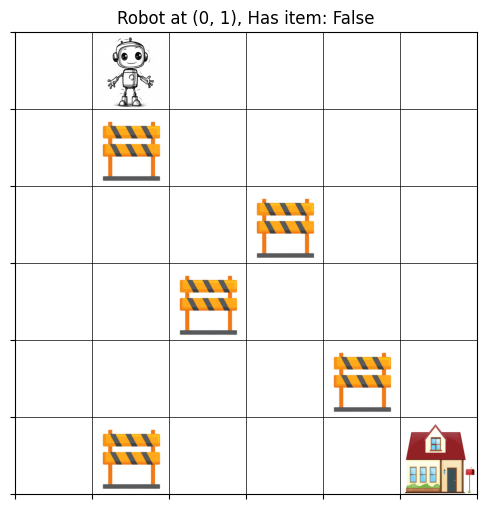



Episode 7: Initial State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



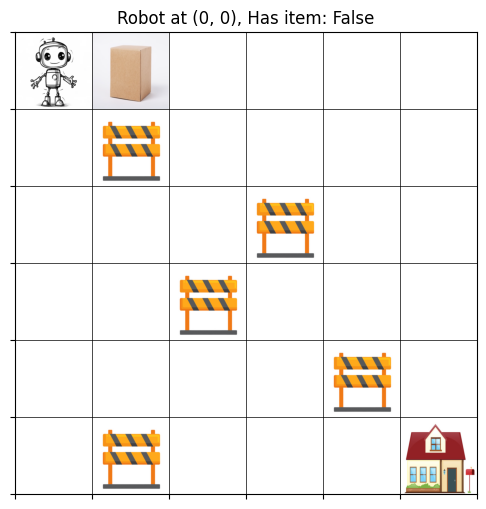

Previous State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



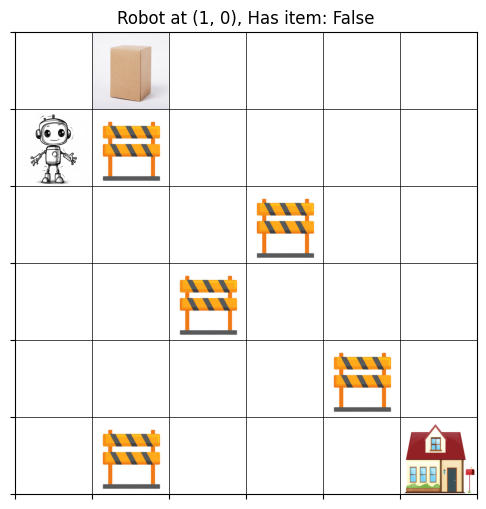

Previous State: ((1, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



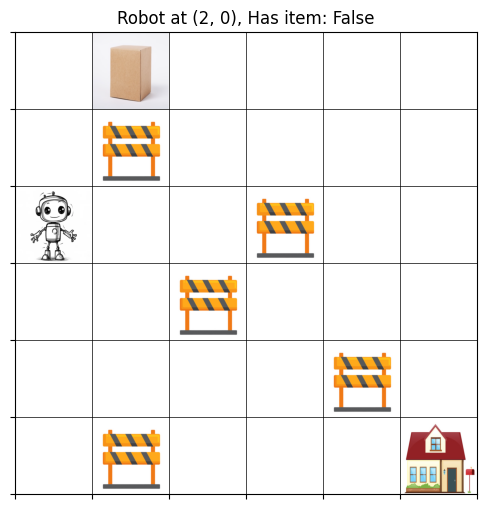

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



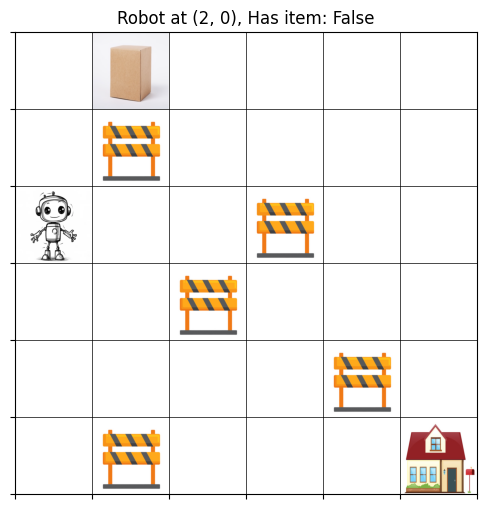

Previous State: ((2, 0), False)
Current State: ((3, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



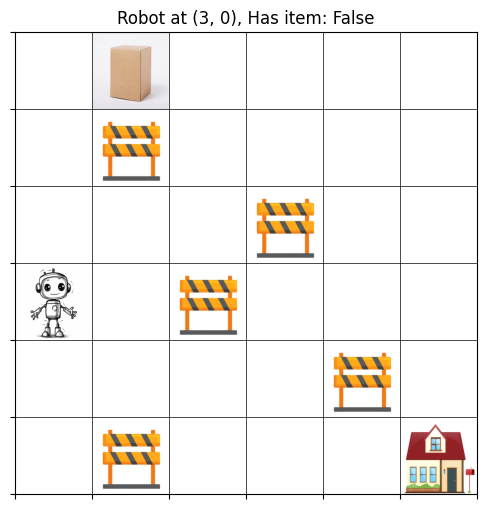

Previous State: ((3, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



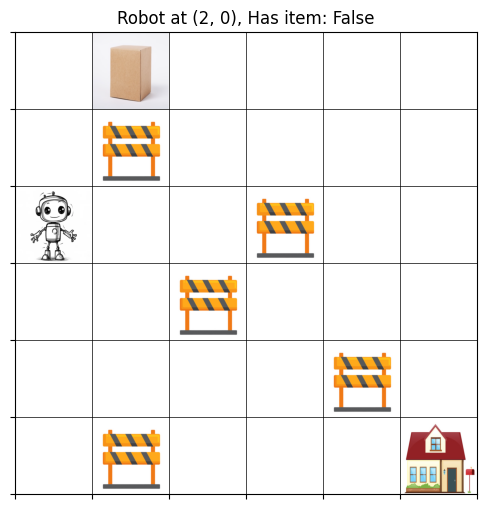

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



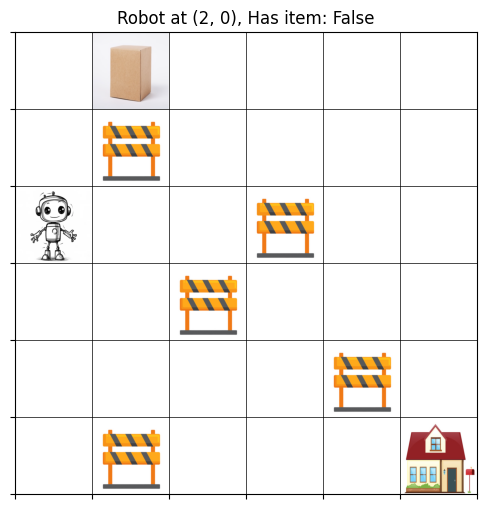

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



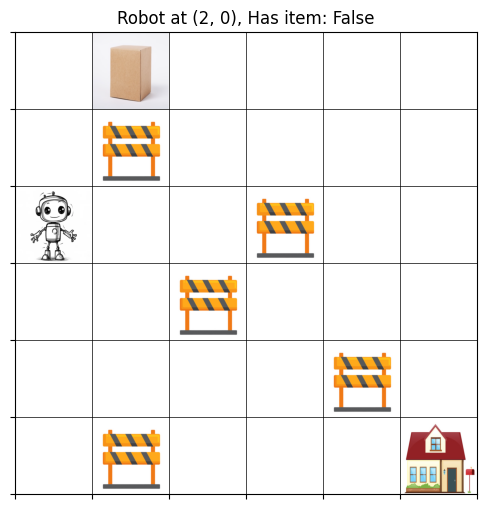

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



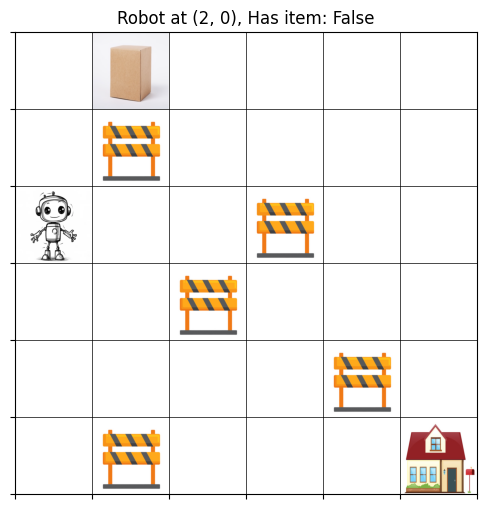

Previous State: ((2, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



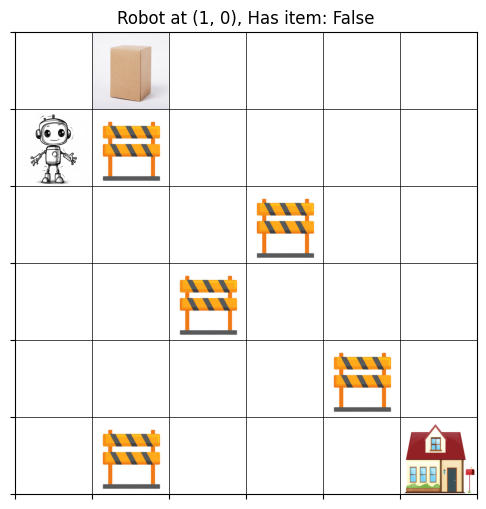



Episode 8: Initial State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Went out of boundary



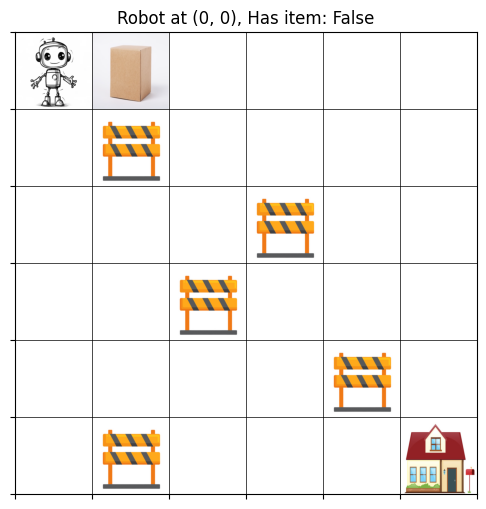

Previous State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



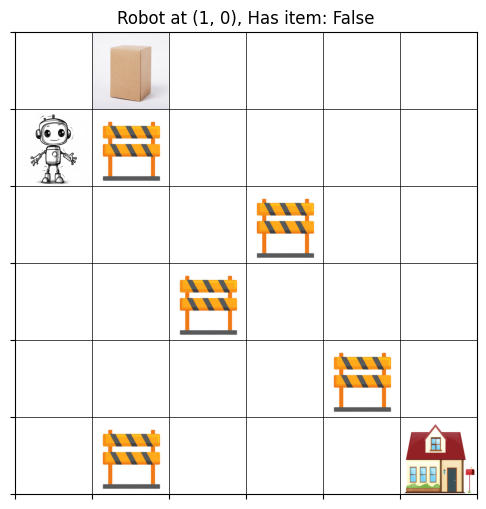

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



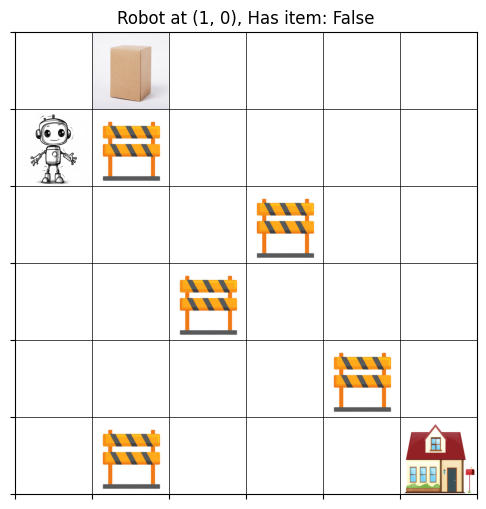

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Right
Reward: -20
Reason: Hit obstacle



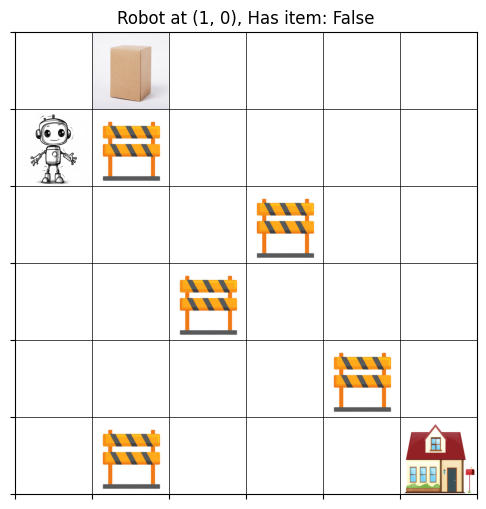

Previous State: ((1, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



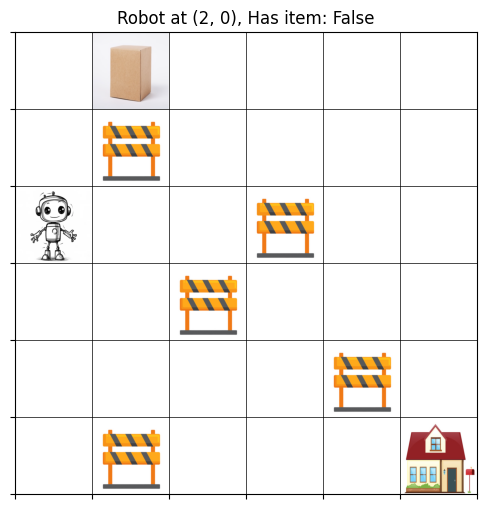

Previous State: ((2, 0), False)
Current State: ((3, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



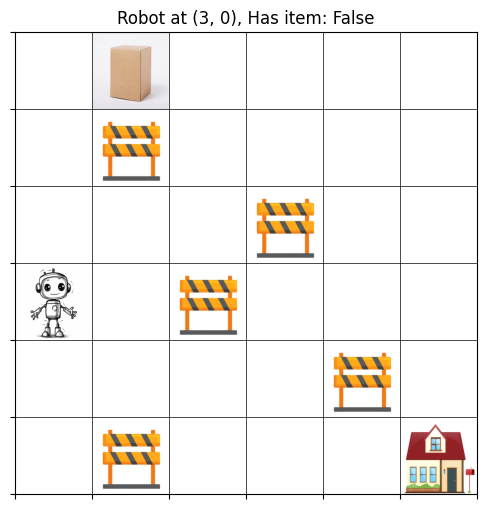

Previous State: ((3, 0), False)
Current State: ((4, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



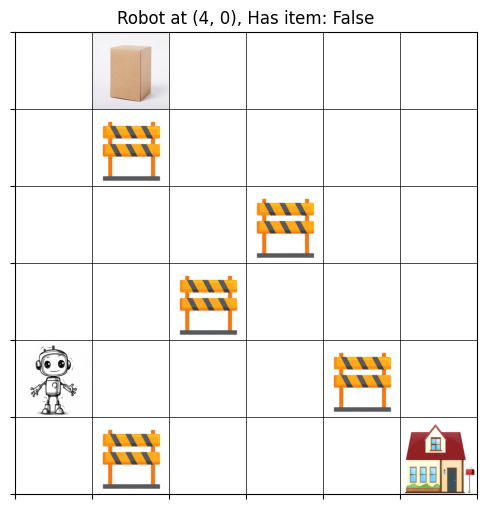

Previous State: ((4, 0), False)
Current State: ((3, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



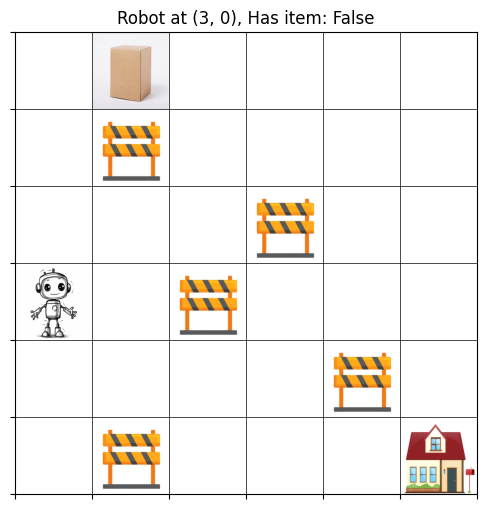

Previous State: ((3, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Up
Reward: -1
Reason: Moved up



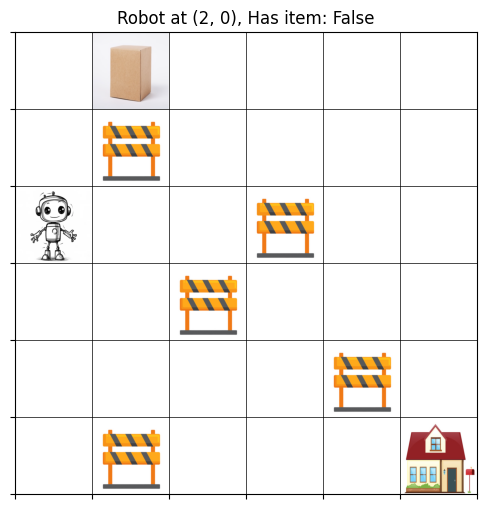

Previous State: ((2, 0), False)
Current State: ((2, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



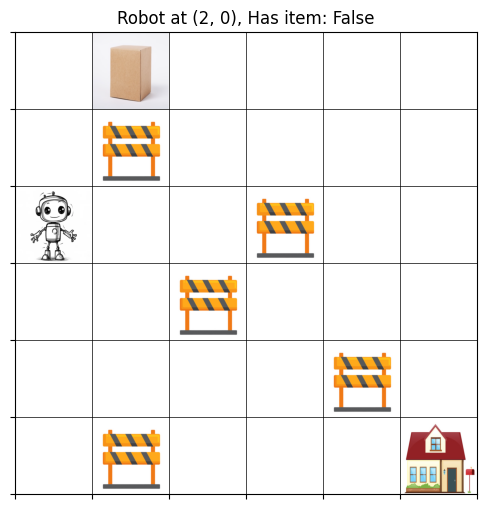



Episode 9: Initial State: ((0, 0), False)
Current State: ((0, 1), False)
Action Taken: Move Right
Reward: -1
Reason: Moved right



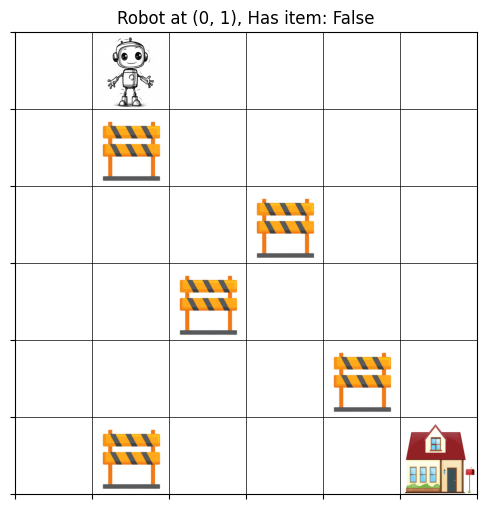

Previous State: ((0, 1), False)
Current State: ((0, 1), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



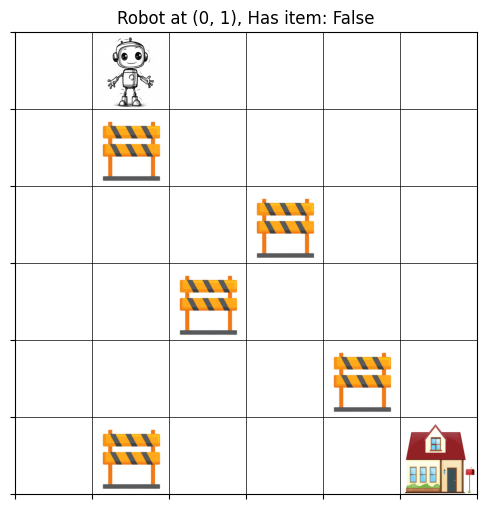

Previous State: ((0, 1), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Moved left



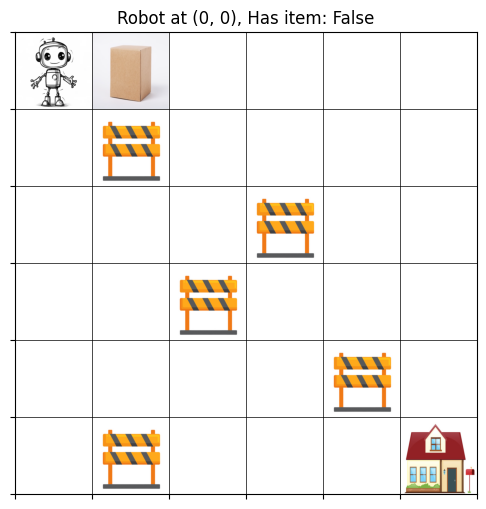

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



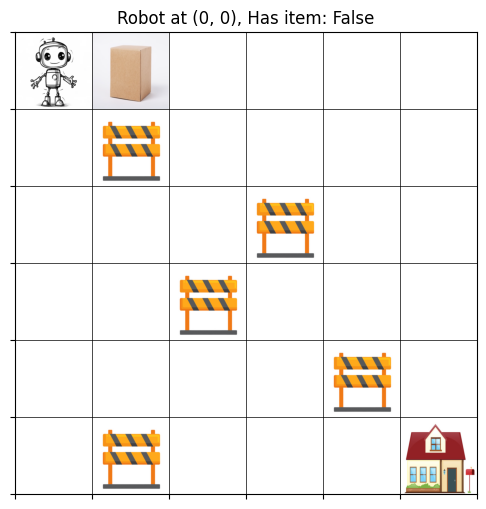

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



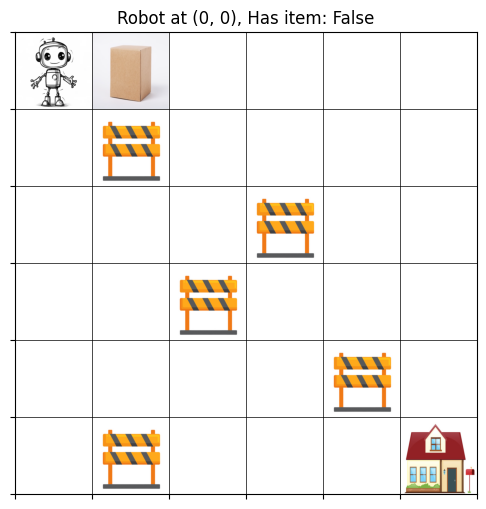

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



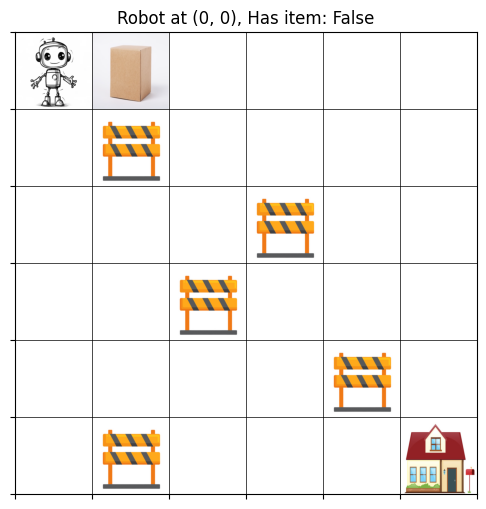

Previous State: ((0, 0), False)
Current State: ((0, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



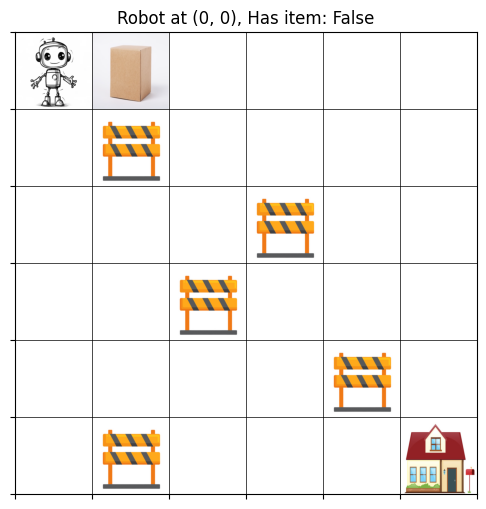

Previous State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



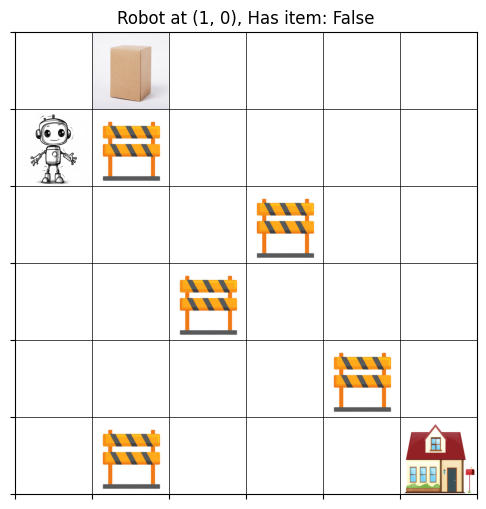

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



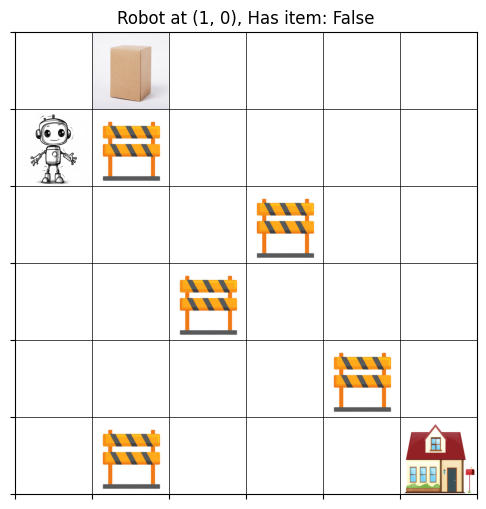

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



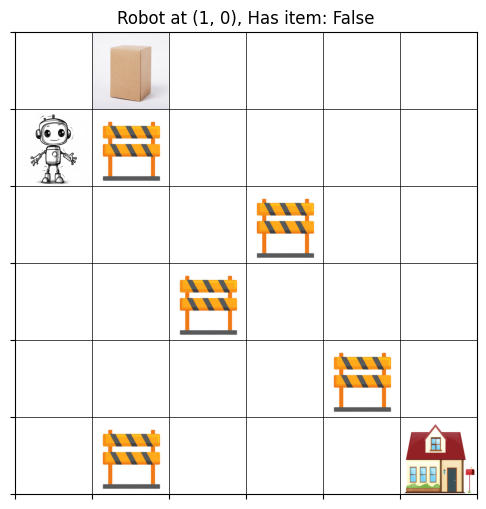



Episode 10: Initial State: ((0, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



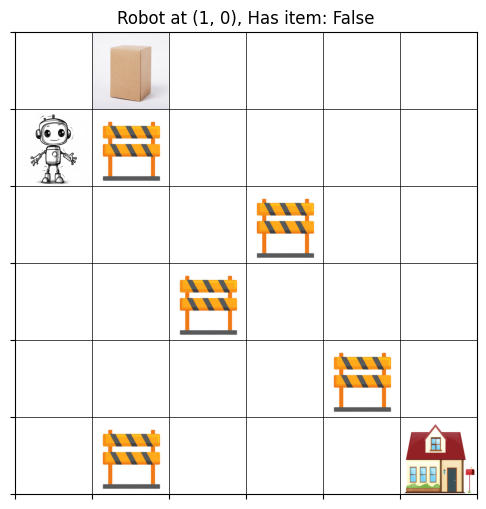

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



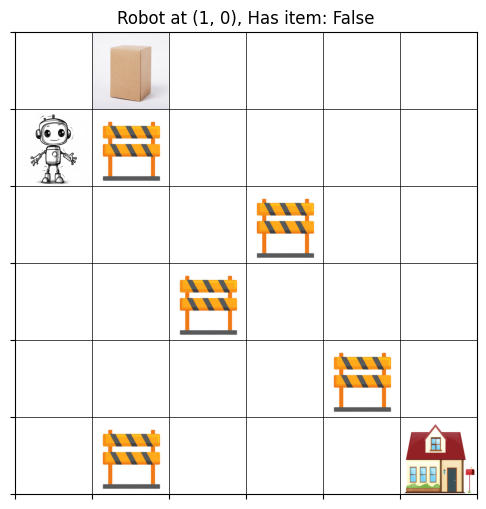

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Right
Reward: -20
Reason: Hit obstacle



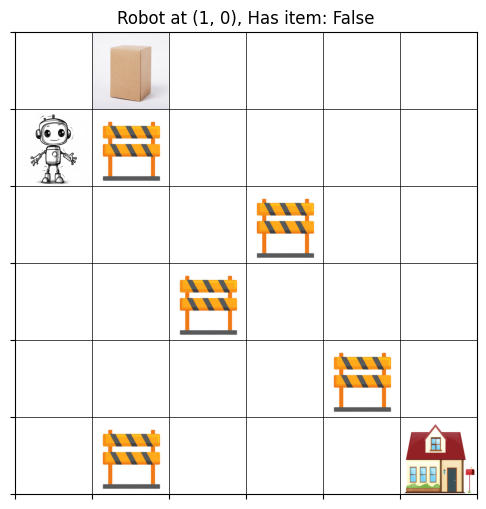

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



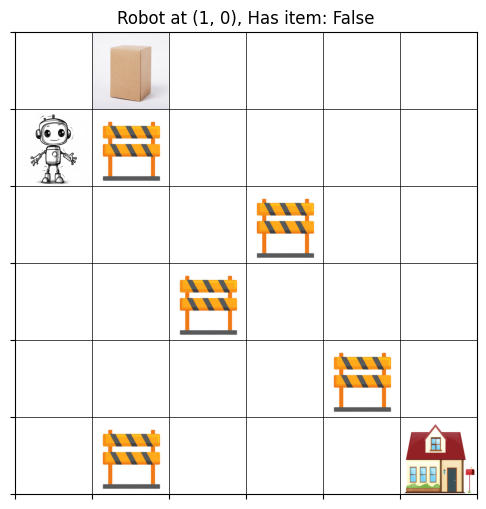

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



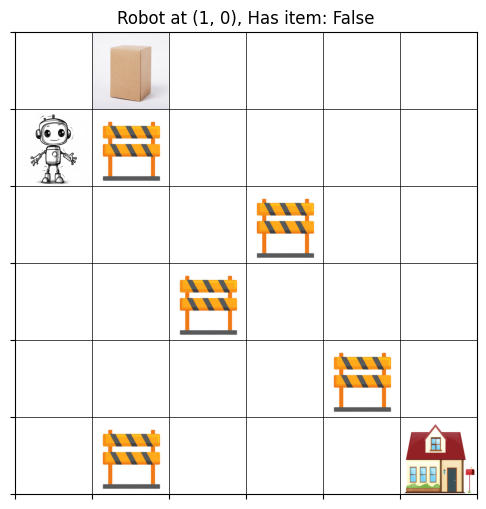

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Drop-off
Reward: -1
Reason: Failed to drop off



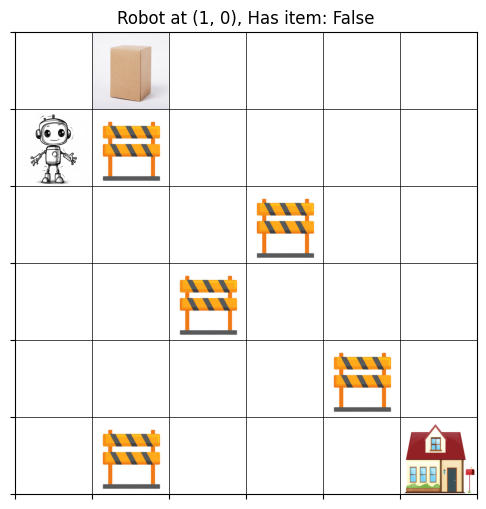

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



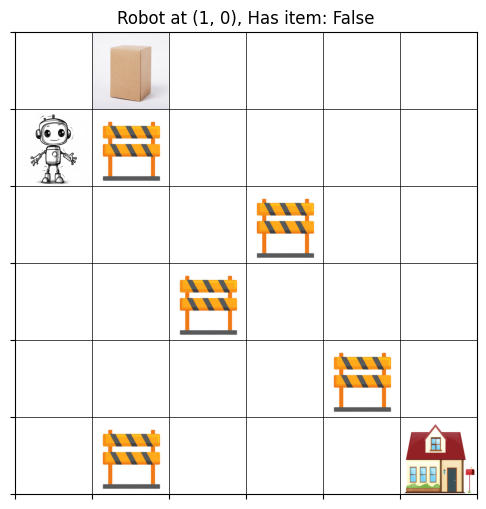

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Move Left
Reward: -1
Reason: Went out of boundary



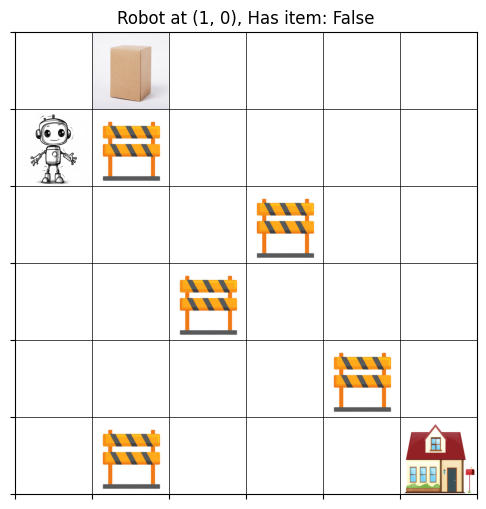

Previous State: ((1, 0), False)
Current State: ((1, 0), False)
Action Taken: Pick-up
Reward: -1
Reason: Failed to pick up



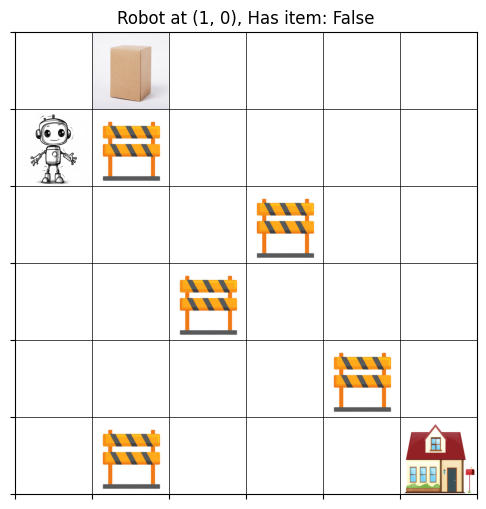

Previous State: ((1, 0), False)
Current State: ((2, 0), False)
Action Taken: Move Down
Reward: -1
Reason: Moved down



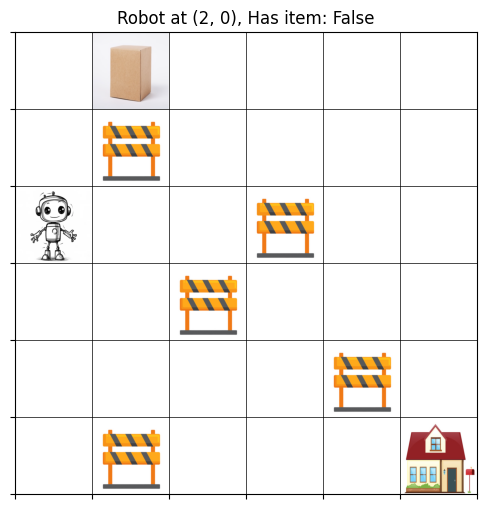

In [109]:
env = WarehouseRobotEnv()

# Simulating Random Agent for 10 Episodes
print("Random Agent for 10 Episodes:")
for episode in range(1, 11):
    state = env.reset()
    prev_state = None
    print(f"Episode {episode}: Initial State: {state}")
    for step in range(10):
        action = env.action_space.sample()  # Random action
        next_state, reward, done, info = env.step(action)

        reason = info["reason"]

        # Printing the current state, previous state, action taken, and reward received
        if prev_state is not None:
            print(f"Previous State: {prev_state}")
        print(f"Current State: {next_state}")
        print(f"Action Taken: {['Move Up', 'Move Down', 'Move Left', 'Move Right', 'Pick-up', 'Drop-off'][action]}")
        print(f"Reward: {reward}")
        print(f"Reason: {reason}")
        print()

        # Rendering the current state
        env.render()

        if done:
            break

        prev_state = next_state

    print("\n")


In [110]:
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, render_during_training=False):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.render_during_training = render_during_training
        self.q_table = np.zeros((env.grid_size, env.grid_size, 2, env.action_space.n))
        self.initial_q_table = np.copy(self.q_table)

    def epsilon_greedy(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state[0][0]][state[0][1]][int(state[1])])

    def train(self, episodes, max_steps):
        rewards_per_episode = []
        epsilon_values = []
        for episode in range(episodes):
            state = self.env.reset()
            action = self.epsilon_greedy(state)
            total_reward = 0
            for _ in range(max_steps):
                if self.render_during_training:
                    self.env.render()

                next_state, reward, done, _ = self.env.step(action)
                next_action = self.epsilon_greedy(next_state)
                self.q_table[state[0][0]][state[0][1]][int(state[1])][action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_state[0][0]][next_state[0][1]][int(next_state[1])][next_action] -
                    self.q_table[state[0][0]][state[0][1]][int(state[1])][action]
                )
                state, action = next_state, next_action
                total_reward += reward
                if done:
                    break
            self.epsilon *= self.epsilon_decay
            epsilon_values.append(self.epsilon)
            rewards_per_episode.append(total_reward)
        return rewards_per_episode, epsilon_values

    def evaluate(self, episodes, max_steps):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = np.argmax(self.q_table[state[0][0]][state[0][1]][int(state[1])])
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        return total_rewards



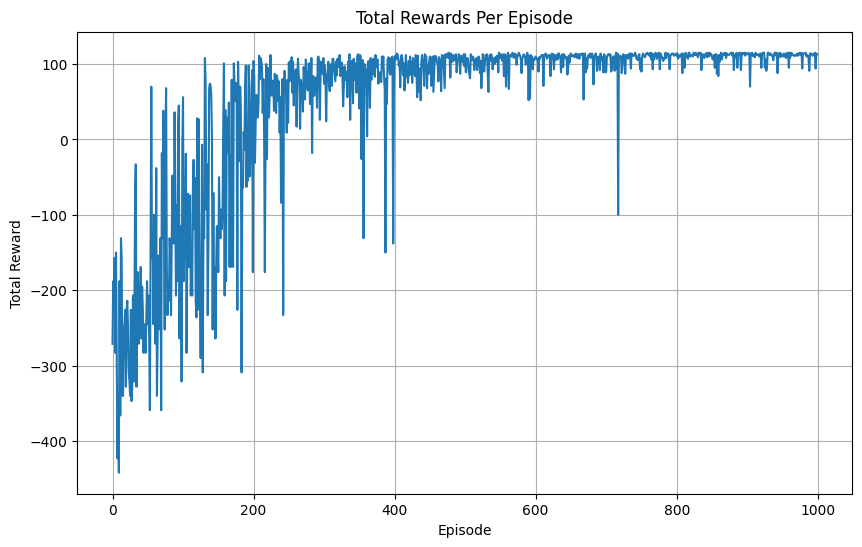

In [111]:
agent = SARSAAgent(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.998, render_during_training=False)

episodes = 1000
max_steps = 100
rewards, epsilons = agent.train(episodes, max_steps)

# Plot total reward per episode
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.title("Total Rewards Per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()


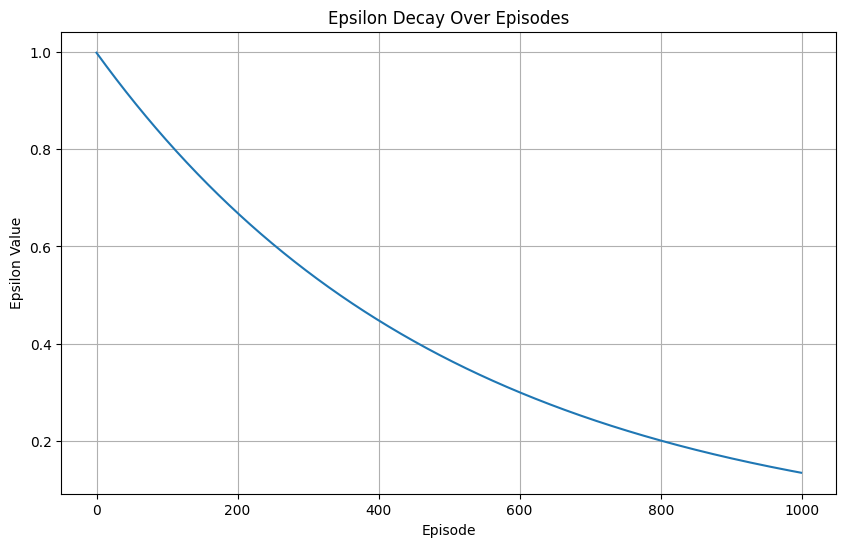

In [112]:
# Plot epsilon decay
plt.figure(figsize=(10, 6))
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.grid()
plt.show()



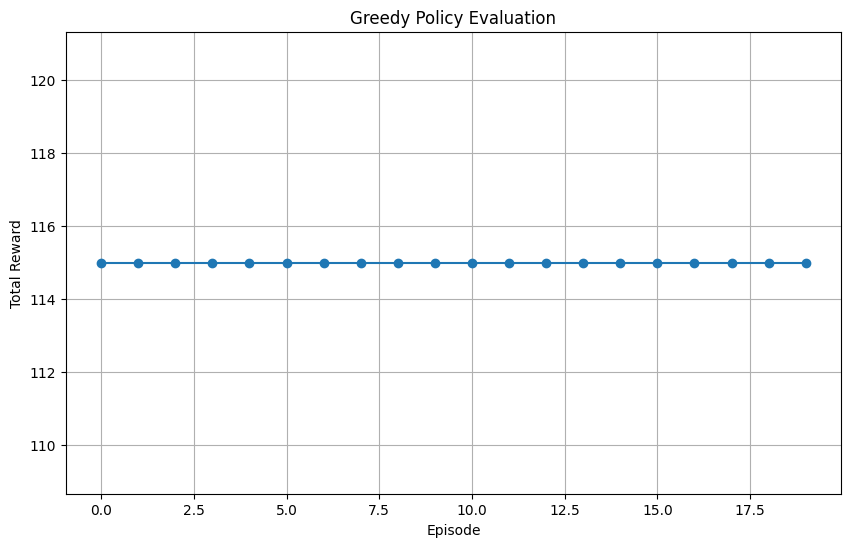

In [113]:
# Evaluate greedy policy
greedy_rewards = agent.evaluate(20, max_steps)
plt.figure(figsize=(10, 6))
plt.plot(greedy_rewards, marker='o')
plt.title("Greedy Policy Evaluation")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()




In [114]:
# Print initial and trained Q-tables
print("\nInitial Q-Table:")
print(agent.initial_q_table)
print("\nTrained Q-Table:")
print(agent.q_table)


Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 